In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline
import matplotlib
import contextily as cx
import math
import numpy as np
import pandas as pd

## Visualizing results of WRF-driven AutoBEM
### And comparing it to NASA POWER (NP) driven AutoBEM

The outline of this notebook gets the building-specific data and stores it in `gdf`
After some elementary visualization of it, it is aggregated to the wrf cells and stored in `cells_gdf`
The geometry on each of these is the same (the centroid of the wrf cell), but `cells_gdf` is just aggregated while `gdf` is not (`gdf` has roughly 1.5 million rows)

Some key findings are presented below, namely an urban-rural split between WRF and NP for many variables. Most variables are somewhat normally distributed around 0% change, but this split is seen when plotted on a map. The surface outside heat emission and anthropogenic emission variables are both drastically lower, however, normally distributed around -20%.

This urban-rural split may be caused by not just urban heat island etc, but higher number of buildings per grid cell the closer you get to central phoenix, so changes in energy usage are more pronounced.

In [2]:
# read in all building results and define what Phoenix metro is
gdf = gpd.read_file('building_results', use_arrow=True)
from shapely.geometry import Polygon
bounds = Polygon([(-113, 34),(-113, 32.8),(-111.2, 32.8),(-111.2, 34)])

In [3]:
gdf['Electricit'].mean()

6832.885233783862

In [4]:
# define a rudimentary percent change
def percent_change(col1,col2):
        return ((col2 - col1) / col1) * 100


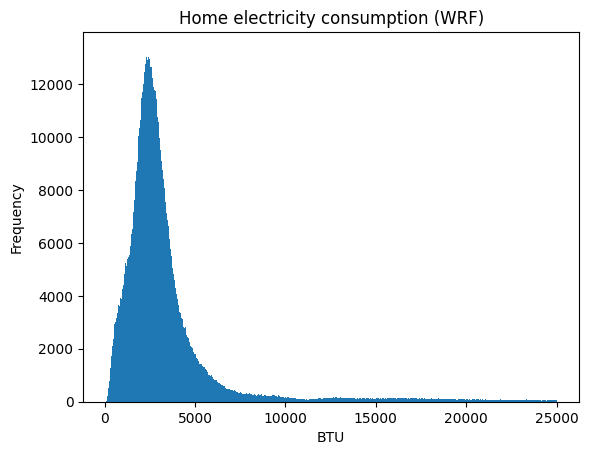

6832.885233783862


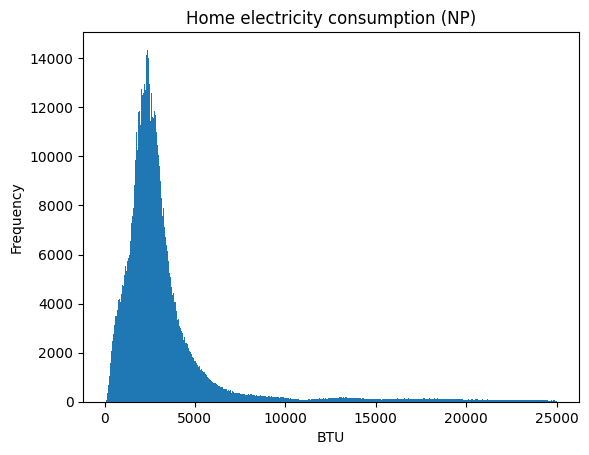

6794.418681582761


In [5]:
# plot home electricity consumption from wrf and from np just to show what kind of data we're dealing with
# this is for EACH BUILDING
ax = gdf[gdf['Electricit'] < 25000]['Electricit'].plot.hist(bins=int(np.sqrt(len(gdf.index))-200))
ax.set_title('Home electricity consumption (WRF)')
ax.set_xlabel('BTU')
plt.show()
print(gdf['Electricit'].mean())
ax = gdf[gdf['Electric_1'] < 25000]['Electric_1'].plot.hist(bins=int(np.sqrt(len(gdf.index))-200))
ax.set_title('Home electricity consumption (NP)')
ax.set_xlabel('BTU')
plt.show()
print(gdf['Electric_1'].mean())

In [6]:
# aggregate into grid cells
foo = gdf.groupby('geometry').sum().reset_index()
cells_gdf = gpd.GeoDataFrame(foo, geometry=foo['geometry'])

16535
20669


<Axes: >

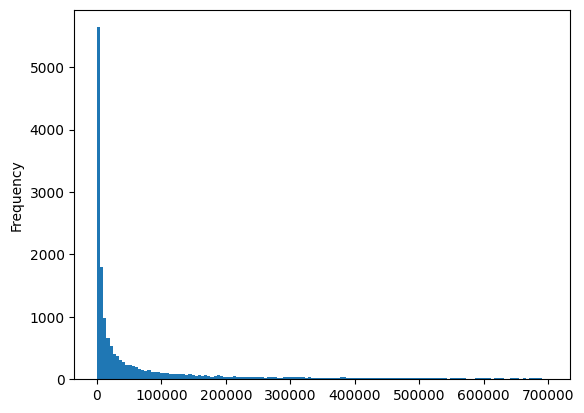

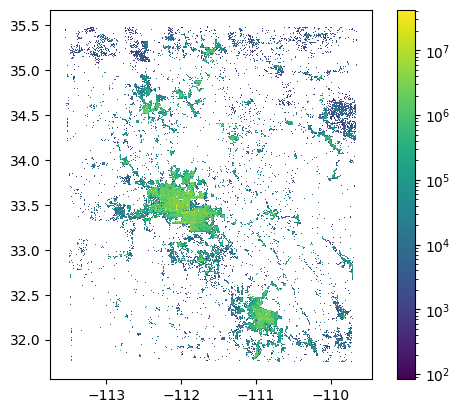

In [7]:
cells_gdf[cells_gdf['Electricit'] < 700000]['Electricit'].plot.hist(bins=int(np.sqrt(len(cells_gdf.index))))
print((cells_gdf['Electricit'] < 700000).sum())
print((cells_gdf['Electricit'] > 0).sum())

cells_gdf.plot(column='Electricit', legend=True, norm=matplotlib.colors.LogNorm(vmin=cells_gdf['Electricit'].min(), vmax=cells_gdf['Electricit'].max()))

(cells_gdf[f'{key}_change'] > 1500).sum()=1662
(cells_gdf[f'{key}_change'] < -1500).sum()=0


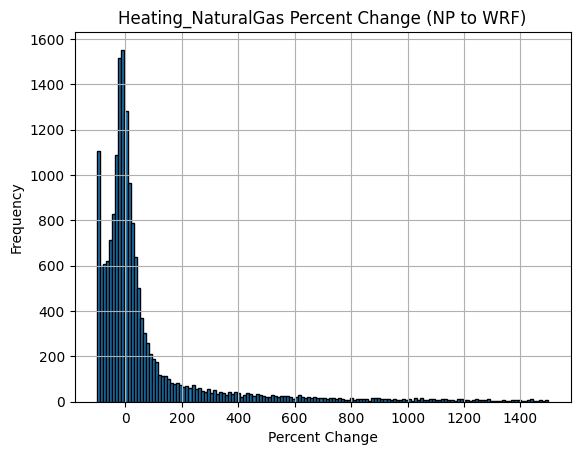

(cells_gdf[f'{key}_change'] > 1500).sum()=0
(cells_gdf[f'{key}_change'] < -1500).sum()=0


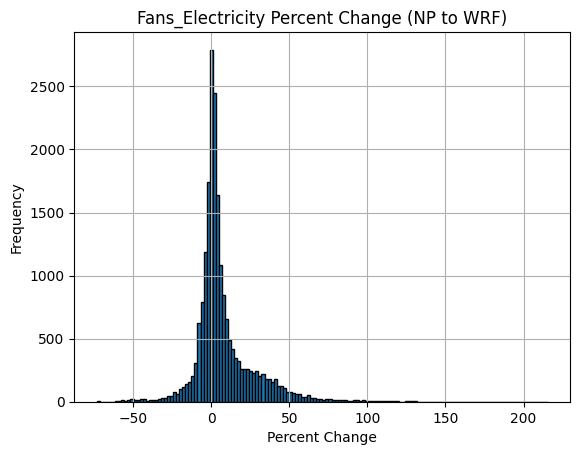

(cells_gdf[f'{key}_change'] > 1500).sum()=0
(cells_gdf[f'{key}_change'] < -1500).sum()=0


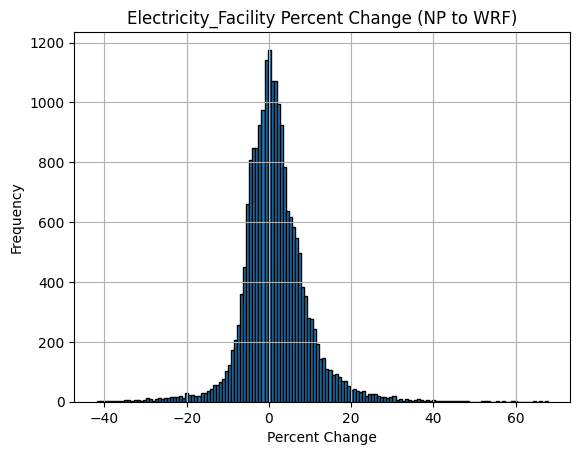

(cells_gdf[f'{key}_change'] > 1500).sum()=0
(cells_gdf[f'{key}_change'] < -1500).sum()=0


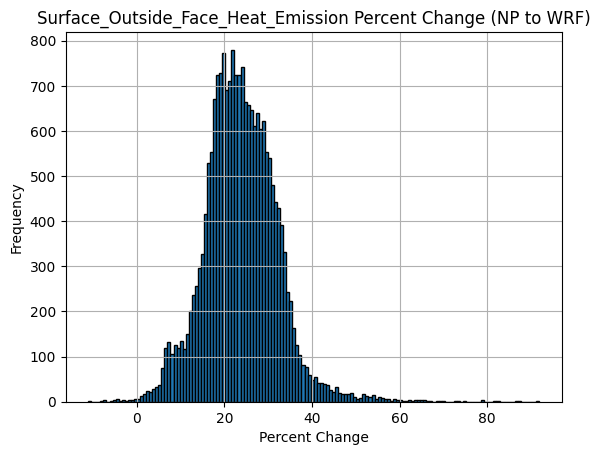

(cells_gdf[f'{key}_change'] > 1500).sum()=0
(cells_gdf[f'{key}_change'] < -1500).sum()=0


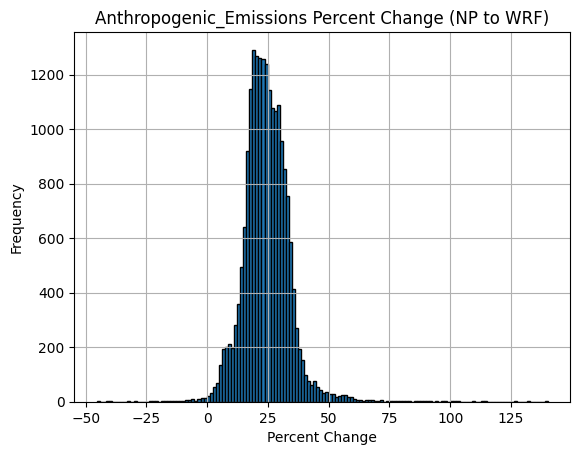

(cells_gdf[f'{key}_change'] > 1500).sum()=0
(cells_gdf[f'{key}_change'] < -1500).sum()=0


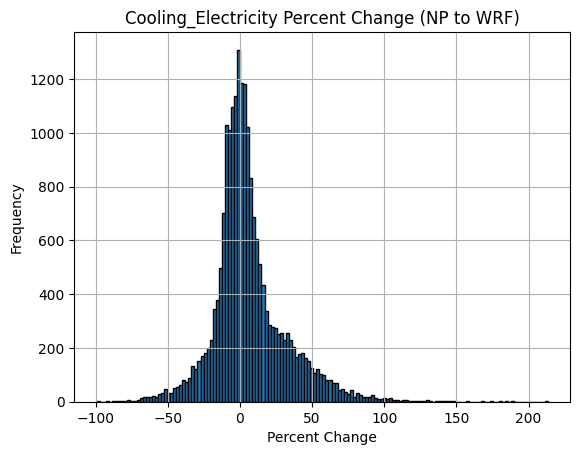

(cells_gdf[f'{key}_change'] > 1500).sum()=94
(cells_gdf[f'{key}_change'] < -1500).sum()=0


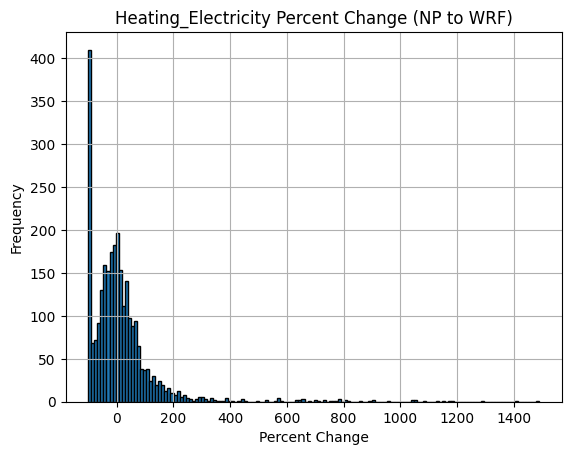

(cells_gdf[f'{key}_change'] > 1500).sum()=1651
(cells_gdf[f'{key}_change'] < -1500).sum()=0


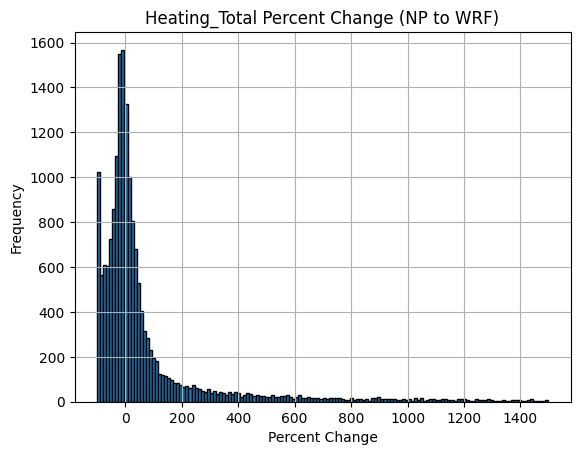

(cells_gdf[f'{key}_change'] > 1500).sum()=56
(cells_gdf[f'{key}_change'] < -1500).sum()=79


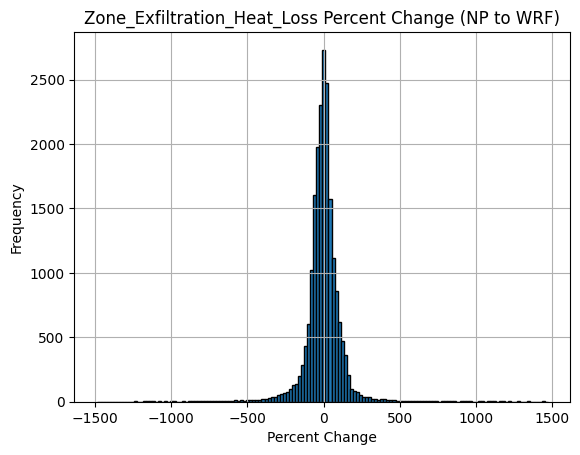

In [8]:
# plot a host of variables that have some meaning and their percent changes from NP to WRF
# many outliers are removed

cols_dict = {
    'Heating_NaturalGas': ('Heating_Na', 'Heating__2'),
    'Fans_Electricity': ('Fans_Elect', 'Fans_Ele_1'),
    'Electricity_Facility': ('Electricit', 'Electric_1'),
    'Surface_Outside_Face_Heat_Emission': ('Surface_Ou', 'Surface__1'),
    'Anthropogenic_Emissions': ('Anthropoge', 'Anthropo_1'),
    'Cooling_Electricity': ('Cooling_El', 'Cooling__1'),
    'Heating_Electricity': ('Heating_El', 'Heating__1'),
    'Heating_Total': ('Heating_To', 'Heating__3'),
    'Zone_Exfiltration_Heat_Loss': ('Zone_Exfil', 'Zone_Exf_1'),
}

for key, val in cols_dict.items():
    cells_gdf[f'{key}_change'] = percent_change(cells_gdf[val[1]], cells_gdf[val[0]])
    print(f"{(cells_gdf[f'{key}_change'] > 1500).sum()=}")
    print(f"{(cells_gdf[f'{key}_change'] < -1500).sum()=}")
    # [(cells_gdf[f'{key}_change'] < 100) & (cells_gdf[f'{key}_change'] > -100)]
    ax = cells_gdf[(cells_gdf[f'{key}_change'] < 1500) & (cells_gdf[f'{key}_change'] > -1500)][f'{key}_change'].replace([np.inf, -np.inf], np.nan).dropna().plot.hist(edgecolor='black',
                                                                                                      bins=math.floor(
                                                                                                          math.sqrt(
                                                                                                              len(cells_gdf.index))) + 5)
    ax.set_title(f'{key} Percent Change (NP to WRF)')
    ax.set_xlabel('Percent Change')
    ax.grid()
    plt.show()



### Rural vs urban split

Here we can see the rural vs urban split in many variables and their percent changes. If WRF is the "more accurate" weather, then we can view this as how NP discrepancies differ along different variables, ie a negative value means that NP is lower than real and positive means it is higher than real.

* Heating natural gas: NP overestimates urban, underestimates rural
* Fan electricity: NP underestimates urban, overestimates rural
* Total electricity: NP underestimates urban, overestimates rural
* Surface outside heat emission: NP underestimates both urban and rural
* Anthropogenic emission: NP underestimates both urban and rural
* Cooling electricity: NP underestimates urban, overestimates rural
* Heating total: NP overestimates urban, underestimates rural


Note: since one or two variables have relatively small values, percent changes may be exaggerated

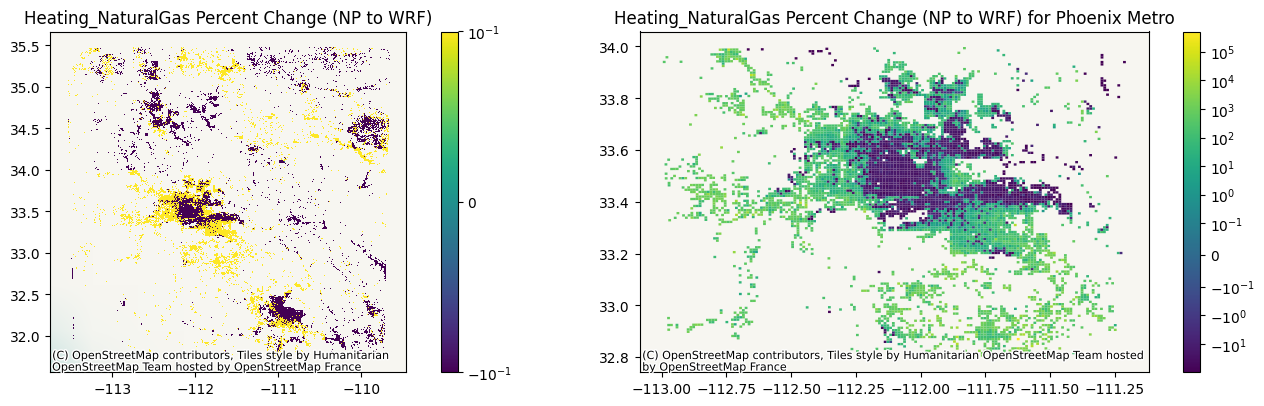

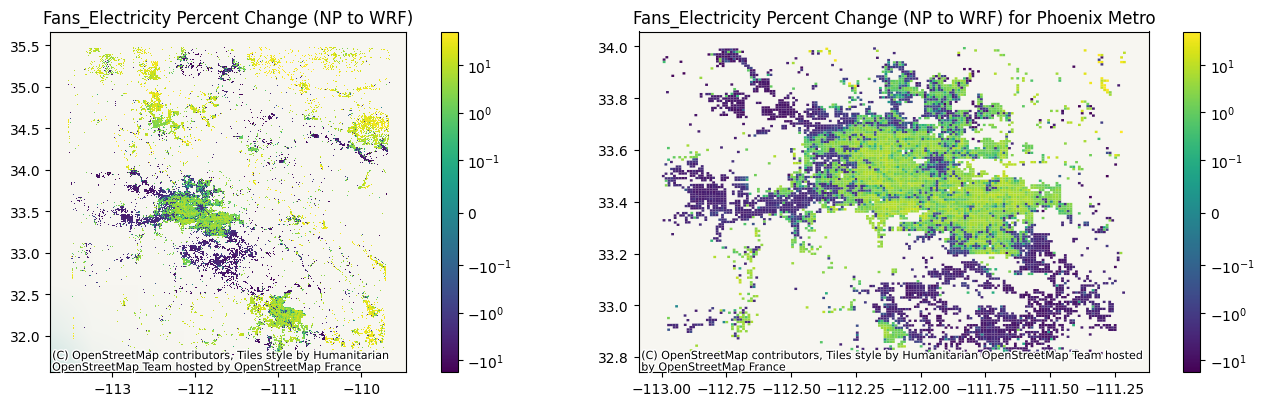

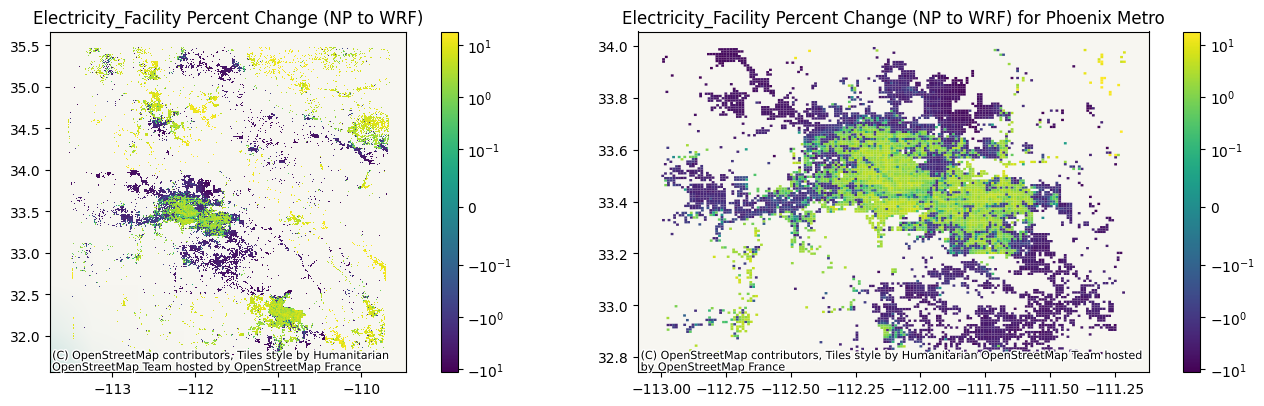

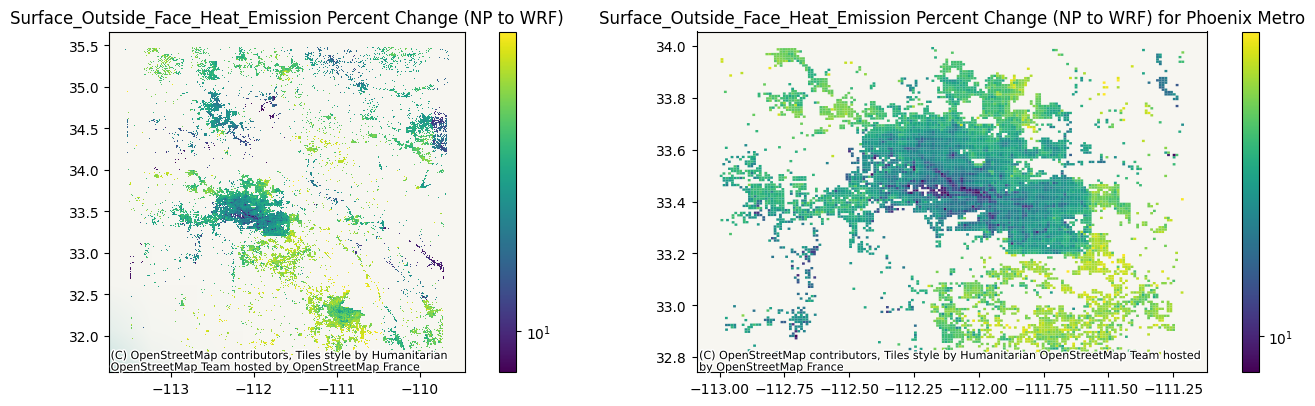

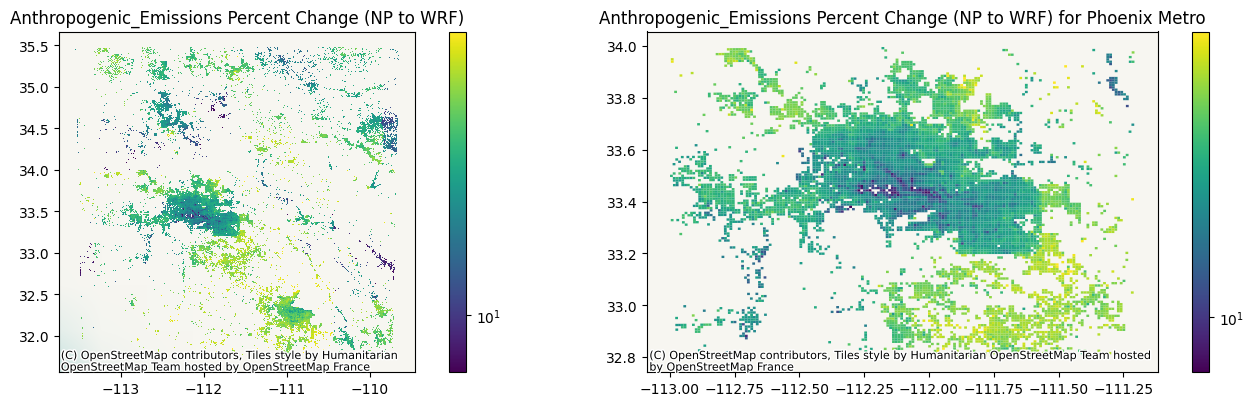

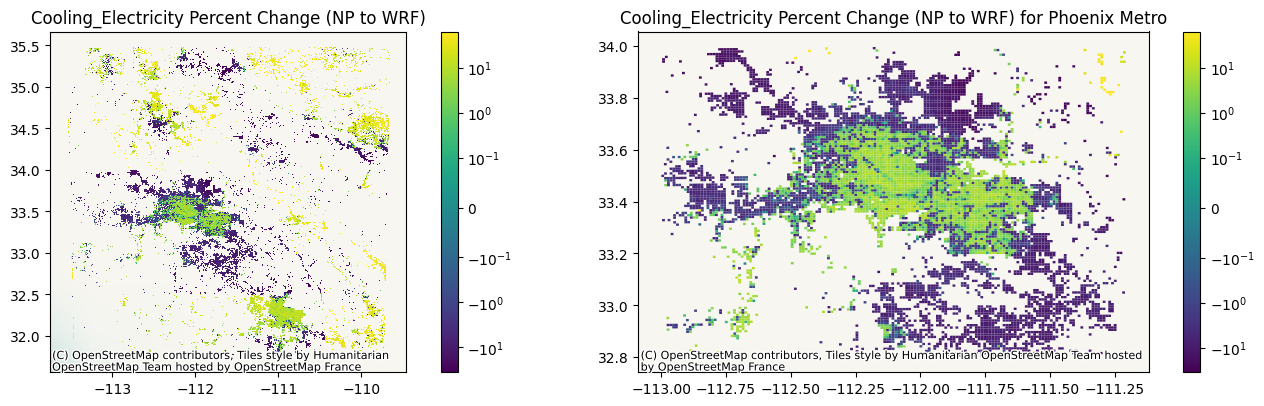

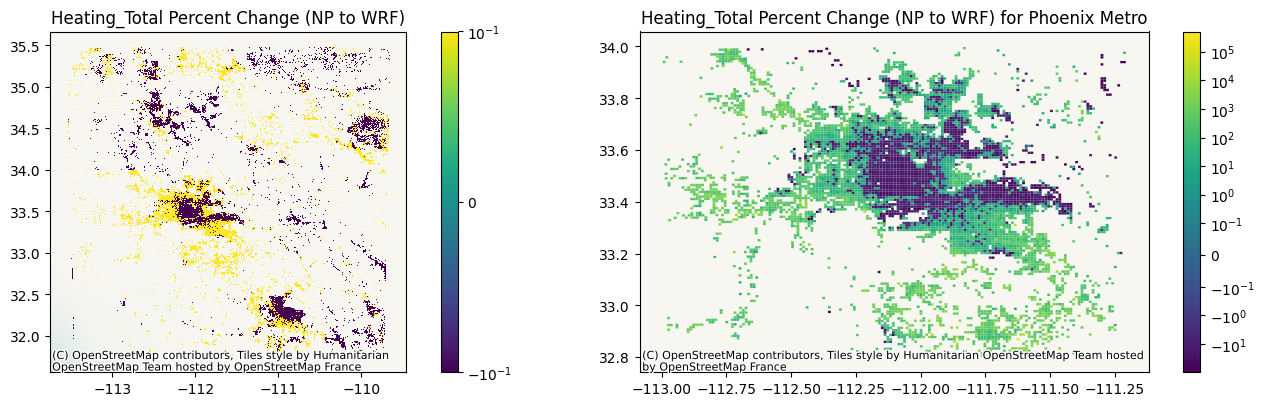

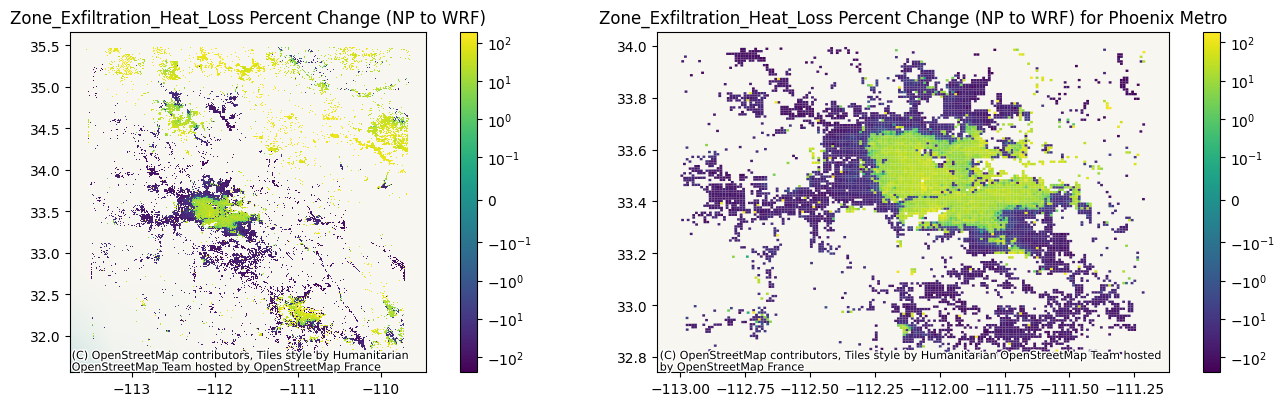

In [9]:
cols_dict = {  # get rid of heating electricity. too many zeroes for percentages to play nice. maybe we can do totals later todo
    'Heating_NaturalGas': ('Heating_Na', 'Heating__2'),
    'Fans_Electricity': ('Fans_Elect', 'Fans_Ele_1'),
    'Electricity_Facility': ('Electricit', 'Electric_1'),
    'Surface_Outside_Face_Heat_Emission': ('Surface_Ou', 'Surface__1'),
    'Anthropogenic_Emissions': ('Anthropoge', 'Anthropo_1'),
    'Cooling_Electricity': ('Cooling_El', 'Cooling__1'),
    'Heating_Total': ('Heating_To', 'Heating__3'),
    'Zone_Exfiltration_Heat_Loss': ('Zone_Exfil', 'Zone_Exf_1'),
}

for key, val in list(cols_dict.items()):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 4))
    fig.tight_layout()
    series = cells_gdf[f'{key}_change']
    lower_quantile = series.quantile(q=.03, interpolation='higher')
    upper_quantile = series.quantile(q=.97, interpolation='lower')
    cells_gdf[(series > lower_quantile) & (series < upper_quantile)].plot(column=f'{key}_change', ax=ax1, legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=lower_quantile, vmax=upper_quantile))
    ax1.set_title(f'{key} Percent Change (NP to WRF)')
    cx.add_basemap(ax1, crs="epsg:4326", zoom=1)
    
    phx_tmp = cells_gdf[(cells_gdf.within(bounds)) & (series > lower_quantile) & (series < upper_quantile)]
    phx_tmp.plot(column=f'{key}_change', ax=ax2, legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=phx_tmp[f'{key}_change'].min(), vmax=phx_tmp[f'{key}_change'].max()))
    ax2.set_title(f'{key} Percent Change (NP to WRF) for Phoenix Metro')
    
    cx.add_basemap(ax2, crs="epsg:4326", zoom=1)
    
    plt.show()


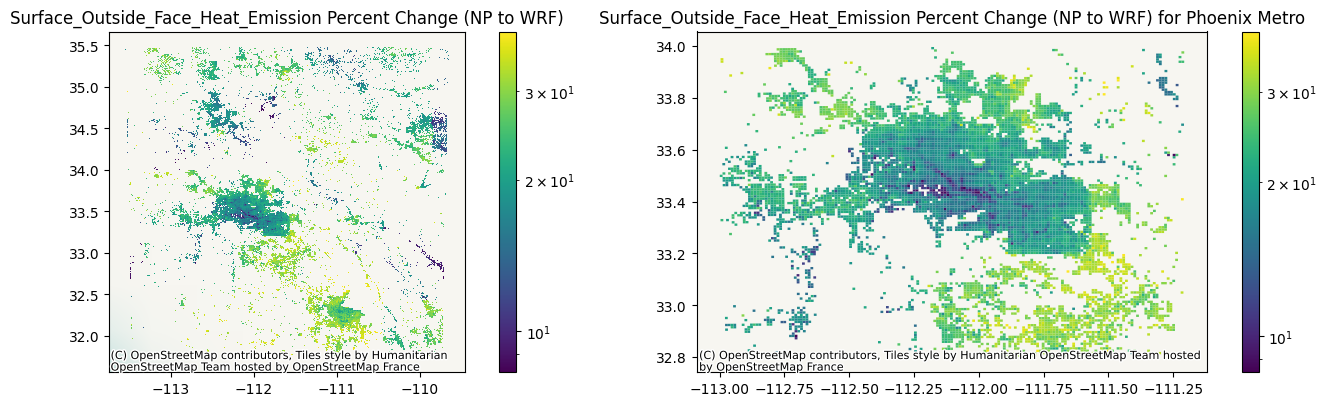

In [10]:
key = 'Surface_Outside_Face_Heat_Emission'
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 4))
fig.tight_layout()
series = cells_gdf[f'{key}_change']
lower_quantile = series.quantile(q=.03, interpolation='higher')
upper_quantile = series.quantile(q=.97, interpolation='lower')
cells_gdf[(series > lower_quantile) & (series < upper_quantile)].plot(column=f'{key}_change', ax=ax1, legend=True, norm=matplotlib.colors.LogNorm(vmin=lower_quantile, vmax=upper_quantile))
ax1.set_title(f'{key} Percent Change (NP to WRF)')
cx.add_basemap(ax1, crs="epsg:4326", zoom=1)

phx_tmp = cells_gdf[(cells_gdf.within(bounds)) & (series > lower_quantile) & (series < upper_quantile)]
phx_tmp.plot(column=f'{key}_change', ax=ax2, legend=True, norm=matplotlib.colors.LogNorm(vmin=phx_tmp[f'{key}_change'].min(), vmax=phx_tmp[f'{key}_change'].max()))
ax2.set_title(f'{key} Percent Change (NP to WRF) for Phoenix Metro')

cx.add_basemap(ax2, crs="epsg:4326", zoom=1)

plt.show()


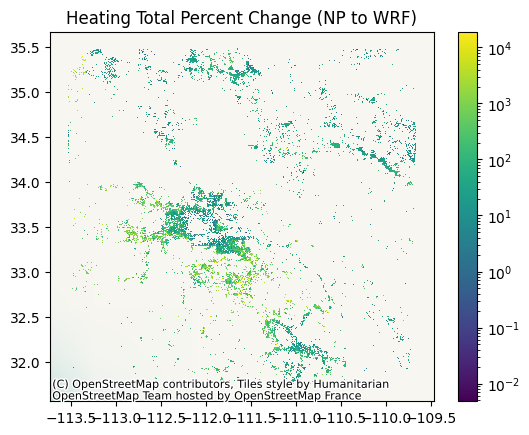

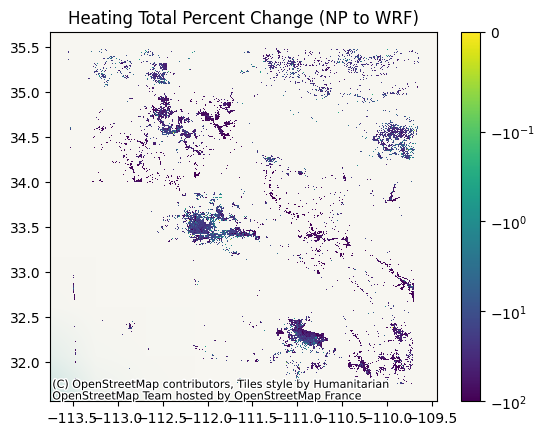

In [11]:
# an elementary map of heating total change percent that is positive and negative
# shows more clearly the distribution against phoenix itself

bar = cells_gdf['Heating_Total_change'].replace([np.inf, -np.inf], np.nan).dropna()

foo = bar[(bar > 0) & (bar < 20_000)]
ax = cells_gdf[(cells_gdf['Heating_Total_change'] > 0) & (cells_gdf['Heating_Total_change'] < 15_000)].plot(column='Heating_Total_change', legend=True, norm=matplotlib.colors.LogNorm(vmin=foo.min(), vmax=foo.max()))
cx.add_basemap(ax, crs="epsg:4326", zoom=1)
ax.set_title('Heating Total Percent Change (NP to WRF)')
plt.show()

foo = bar[(bar < 0)]
ax = cells_gdf[(cells_gdf['Heating_Total_change'] < 0)].plot(column='Heating_Total_change', legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=foo.min(), vmax=0))
ax.set_title('Heating Total Percent Change (NP to WRF)')
cx.add_basemap(ax, crs="epsg:4326", zoom=1)
plt.show()

In [12]:
# now i want to compare NP to WRF. see what we actually really changed in terms of inputs to energyplus

# get np stuff
import os
np_epws = os.listdir('AZ_NP_EPW')
np_epws.sort()
np_epws = [os.path.join('AZ_NP_EPW', x) for x in np_epws]
cols = [0,1,2,3,4,6,7,8,9,12,14,15,20,21,22]
names = ['!Year', 'Month', 'Day', 'Hour', 'Minute', 'Dry bulb temperature {C}', 
         'Dew point temperature {C}', 'Relative Humidity {%}', 'Atmospheric Pressure {Pa}',
         'Horizontal Infrared Radiation Intensity from Sky {Wh/m2}', 'Direct Normal Radiation {Wh/m2}',
         'Diffuse Horizontal Radiation {Wh/m2}', 'Wind Direction {deg}', 'Wind Speed {m/s}', 'Total Sky Cover {.1}']
np_dfs = [pd.read_csv(x, header=None, skiprows=3265, nrows=384, usecols=cols, names=names) for x in np_epws]
counties = gpd.read_file('supplemental_materials/az_counties').to_crs('epsg:4326')
counties['NAME'] = counties['NAME'].str.title().str.replace(' ', '_')
counties.sort_values(by=['NAME'], inplace=True)
for i in range(len(counties)):
    np_dfs[i]['geometry'] = [counties.iloc[i]['geometry']] * len(np_dfs[i].index)
np_gdf = gpd.GeoDataFrame(pd.concat(np_dfs))
np_gdf

!Year  Month  Day  Hour  Minute  Dry bulb temperature {C}  \
0     2020      5   15    18       0                     21.79   
1     2020      5   15    19       0                     19.76   
2     2020      5   15    20       0                     15.33   
3     2020      5   15    21       0                     13.94   
4     2020      5   15    22       0                     12.94   
..     ...    ...  ...   ...     ...                       ...   
379   2020      5   31    13       0                     35.20   
380   2020      5   31    14       0                     36.27   
381   2020      5   31    15       0                     37.09   
382   2020      5   31    16       0                     37.37   
383   2020      5   31    17       0                     37.00   

     Dew point temperature {C}  Relative Humidity {%}  \
0                        -2.13                  19.94   
1                        -1.10                  24.50   
2                         0.43                  36.12   
3                         0.39                  39.44   
4                         0.31                  41.88   
..                         ...                    ...   
379                       3.50                  13.81   
380                       2.73                  12.25   
381                       2.04                  11.12   
382                       1.41                  10.50   
383                       0.97                  10.38   

     Atmospheric Pressure {Pa}  \
0                      79567.0   
1                      79588.0   
2                      79628.0   
3                      79676.0   
4                      79717.0   
..                         ...   
379                    99284.0   
380                    99207.0   
381                    99120.0   
382                    99040.0   
383                    98987.0   

     Horizontal Infrared Radiation Intensity from Sky {Wh/m2}  \
0                                               290.52          
1                                               283.48          
2                                               278.73          
3                                               275.30          
4                                               271.80          
..                                                 ...          
379                                             378.38          
380                                             384.02          
381                                             384.85          
382                                             388.12          
383                                             381.00          

     Direct Normal Radiation {Wh/m2}  Diffuse Horizontal Radiation {Wh/m2}  \
0                             806.20                                 53.85   
1                             516.34                                 34.46   
2                               0.00                                  0.00   
3                               0.00                                  0.00   
4                               0.00                                  0.00   
..                               ...                                   ...   
379                           938.69                                 83.82   
380                           935.41                                101.87   
381                           946.48                                 88.21   
382                           888.11                                101.91   
383                           861.45                                 85.80   

     Wind Direction {deg}  Wind Speed {m/s}  Total Sky Cover {.1}  \
0                  277.00              6.02                  0.13   
1                  283.36              4.53                  0.06   
2                  291.36              3.24                  0.06   
3                  297.88              3.21                  0.05   
4                  302.34              3.12            

In [13]:
wrf_gdf = gpd.read_file('./all_epws', use_arrow=True)

<Axes: >

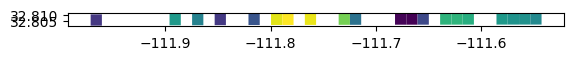

In [14]:
a = wrf_gdf[(wrf_gdf['Day'] == 16) & (wrf_gdf['Hour'] == 15) & (wrf_gdf.within(bounds))]
# a.plot(column='Dew point')
a.iloc[0:20].plot(column='Dew point')

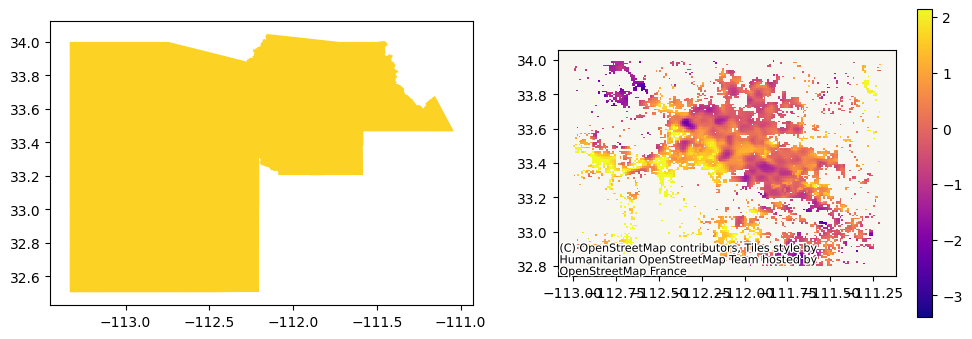

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

a = counties.loc[counties['NAME'] == 'Maricopa'].geometry
np_plot_data = np_gdf[(np_gdf['Day'] == 16) & (np_gdf['Hour'] == 15) & (np_gdf['geometry'] == a.values[0])]

wrf_plot_data = wrf_gdf[(wrf_gdf['Day'] == 16) & (wrf_gdf['Hour'] == 15) & (wrf_gdf.within(bounds)) & (wrf_gdf['Dew point'] < 10)]

my_vmin = min(np_plot_data['Dew point temperature {C}'].min(), wrf_plot_data['Dew point'].min())-.5
my_vmax = min(np_plot_data['Dew point temperature {C}'].max(), wrf_plot_data['Dew point'].max())+.5

np_plot_data.plot(ax=ax1, column='Dew point temperature {C}', cmap='plasma', vmin=my_vmin, vmax=my_vmax)

wrf_plot_data.plot(ax=ax2, legend=True, column='Dew point', cmap='plasma', vmin=my_vmin, vmax=my_vmax)
cx.add_basemap(ax2, crs="epsg:4326",zoom=1)



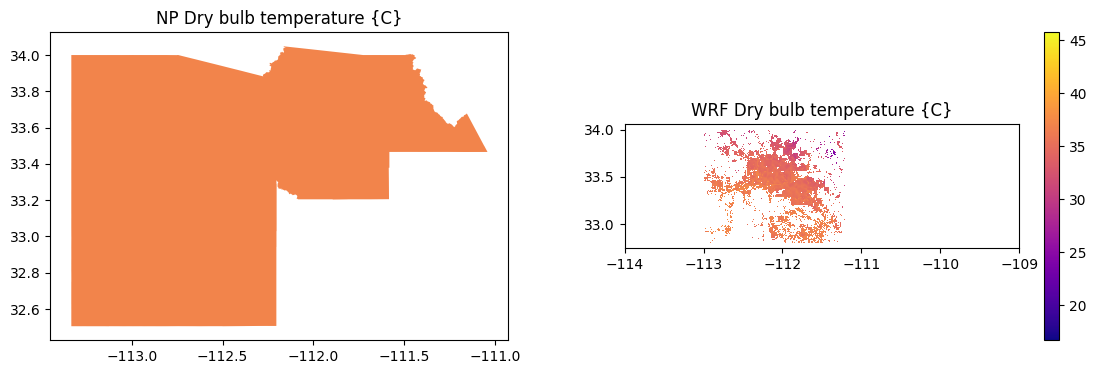

69    37.13
Name: Dry bulb temperature {C}, dtype: float64
35.15874051134956


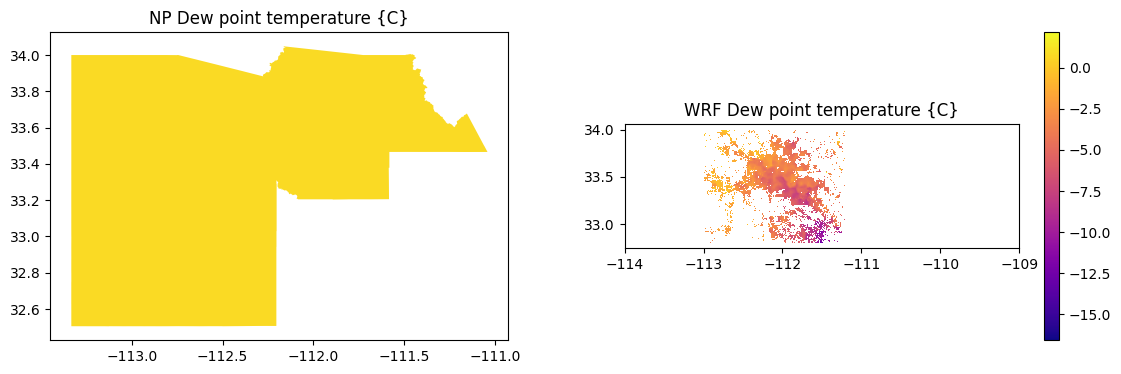

69    0.8
Name: Dew point temperature {C}, dtype: float64
-4.113007667493603


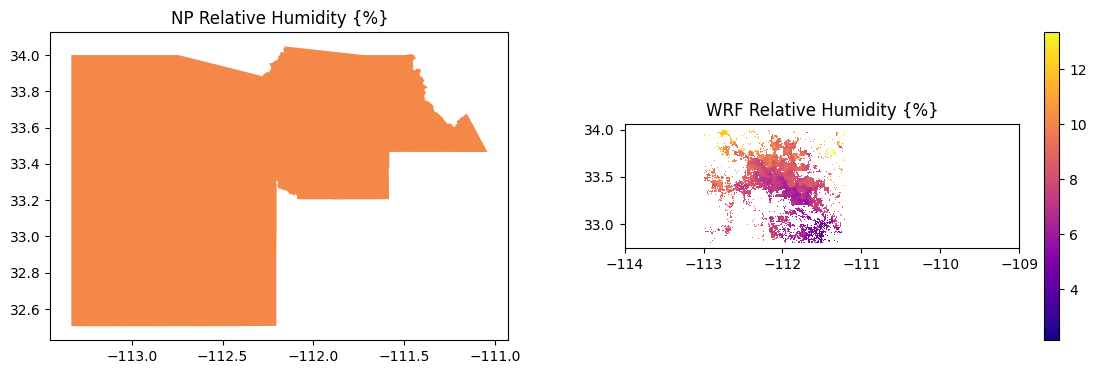

69    10.12
Name: Relative Humidity {%}, dtype: float64
8.05469674636126


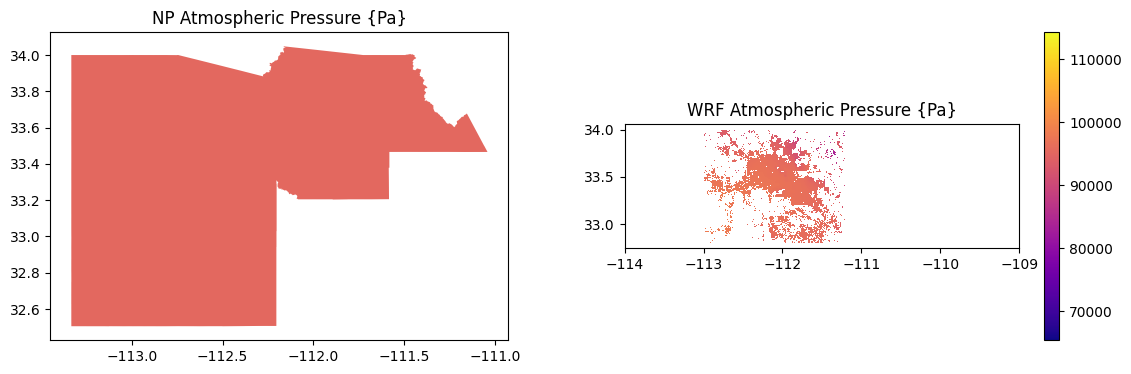

69    95220.0
Name: Atmospheric Pressure {Pa}, dtype: float64
95888.54053088457


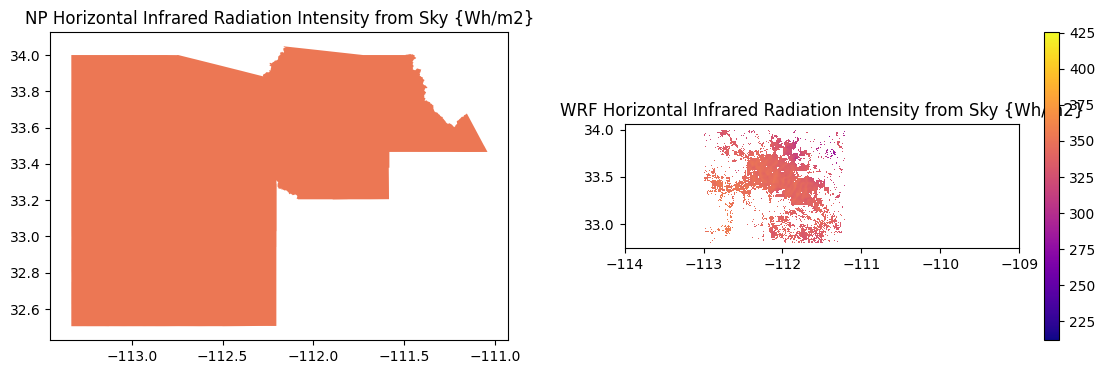

69    353.35
Name: Horizontal Infrared Radiation Intensity from Sky {Wh/m2}, dtype: float64
339.1576880767643


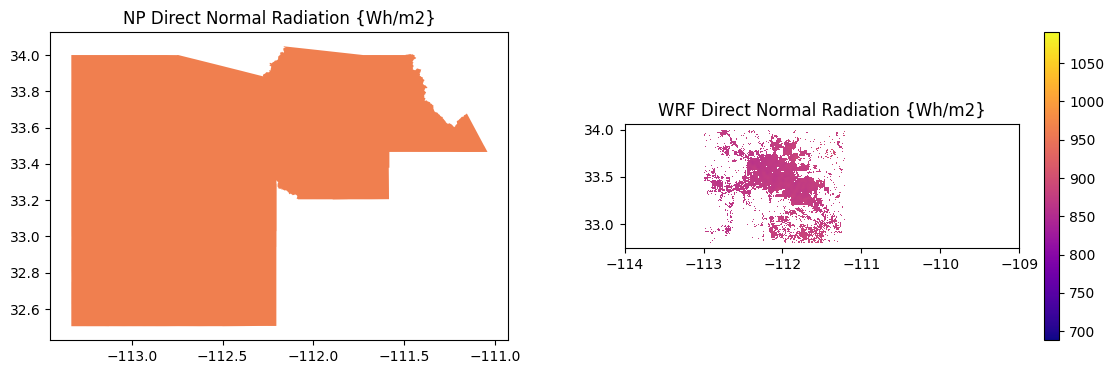

69    963.51
Name: Direct Normal Radiation {Wh/m2}, dtype: float64
873.5119211418353


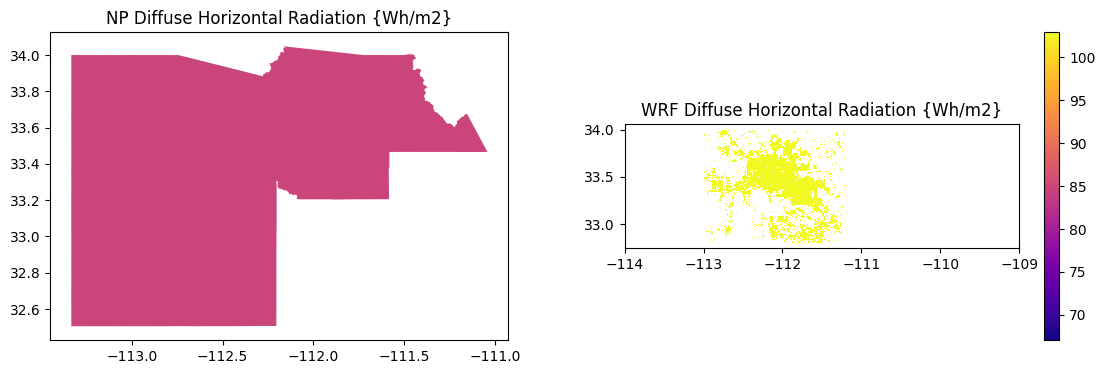

69    84.78
Name: Diffuse Horizontal Radiation {Wh/m2}, dtype: float64
218.377980298528


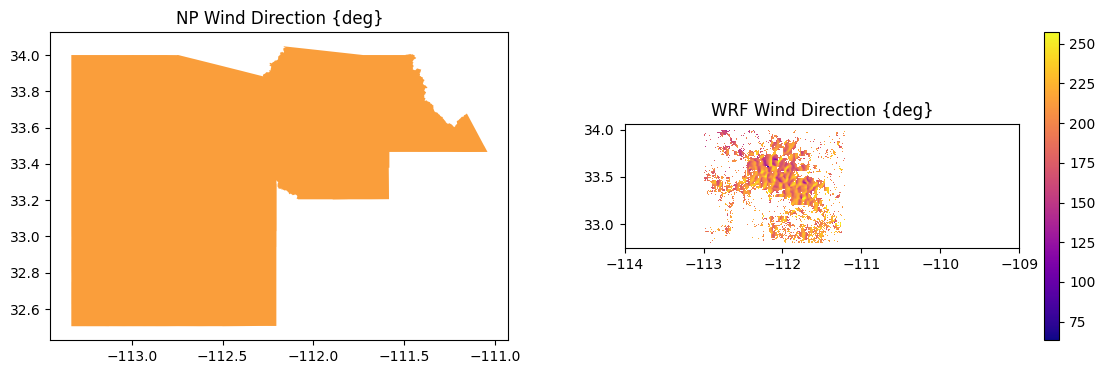

69    213.3
Name: Wind Direction {deg}, dtype: float64
199.9552097159169


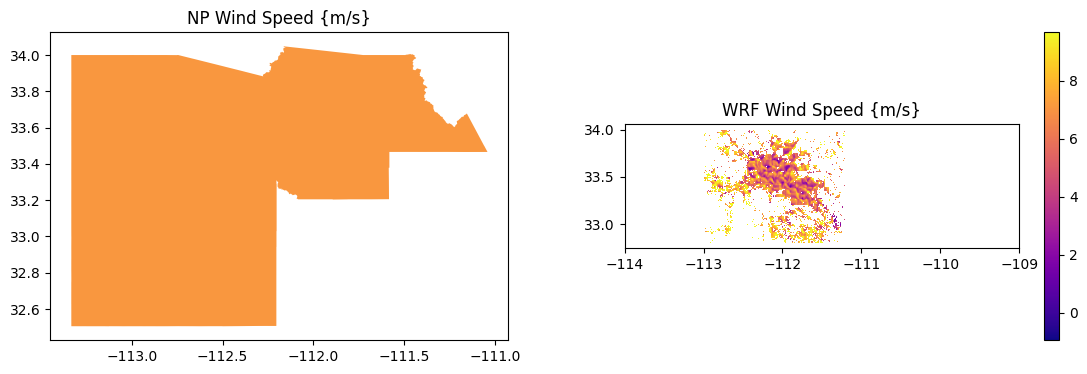

69    7.06
Name: Wind Speed {m/s}, dtype: float64
6.647096180687853


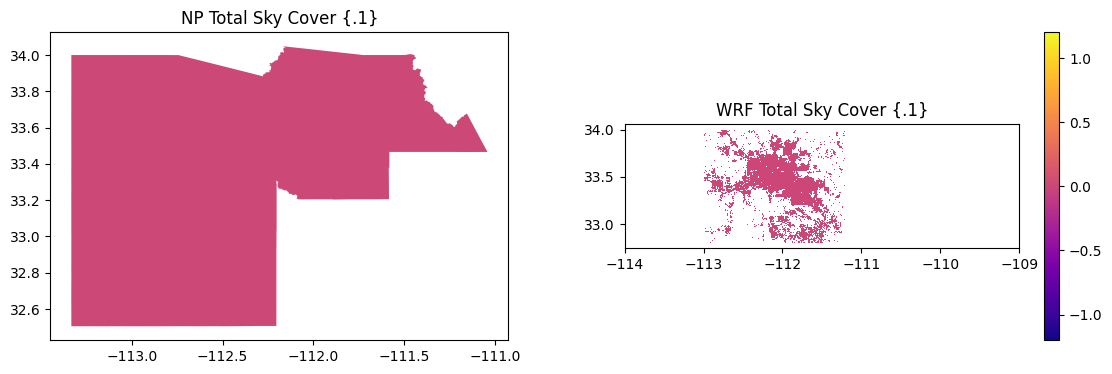

69    0.01
Name: Total Sky Cover {.1}, dtype: float64
0.0


In [16]:
for np_col, wrf_col in zip(np_gdf.columns[5:-1], wrf_gdf.columns[5:-1]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    
    a = counties.loc[counties['NAME'] == 'Maricopa'].geometry
    np_plot_data = np_gdf[(np_gdf['Day'] == 18) & (np_gdf['Hour'] == 15) & (np_gdf['geometry'] == a.values[0])]
    wrf_plot_data = wrf_gdf[(wrf_gdf['Day'] == 18) & (wrf_gdf['Hour'] == 15) & (wrf_gdf.within(bounds))]
    
    my_vmin = min(np_plot_data[np_col].min(), wrf_plot_data[wrf_col].min())-1
    my_vmax = min(np_plot_data[np_col].max(), wrf_plot_data[wrf_col].max())+1
    
    np_plot_data.plot(ax=ax1, column=np_col, cmap='plasma', vmin=my_vmin-.2*abs(my_vmin), vmax=my_vmax+.2*abs(my_vmax))
    ax1.set_title(f'NP {np_col}')
    
    wrf_plot_data.plot(ax=ax2, column=wrf_col, cmap='plasma', vmin=my_vmin-.2*abs(my_vmin), vmax=my_vmax+.2*abs(my_vmax), legend=True)
    # cx.add_basemap(ax2, crs="epsg:4326")
    ax2.set_title(f'WRF {np_col}')
    ax2.set_xticks(ax.get_xticks()[::2])
    plt.show()
    
    # sm = plt.cm.ScalarMappable(cmap='plasma', norm=matplotlib.colors.Normalize(vmin=my_vmin, vmax=my_vmax))
    # sm._A = []  # Required for adding the colorbar
    # fig.colorbar(sm, ax=[ax1, ax2], orientation='horizontal', fraction=0.05, pad=0.1)
    # plt.show()

    print(np_plot_data[np_col])
    print(wrf_plot_data[wrf_col].mean())




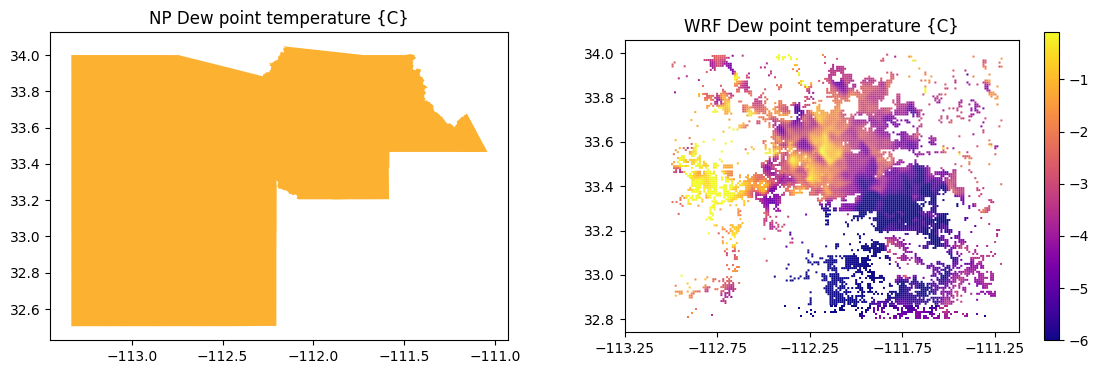

In [17]:
np_col = 'Dew point temperature {C}'
wrf_col = 'Dew point'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

a = counties.loc[counties['NAME'] == 'Maricopa'].geometry
np_plot_data = np_gdf[(np_gdf['Day'] == 23) & (np_gdf['Hour'] == 15) & (np_gdf['geometry'] == a.values[0])]
wrf_plot_data = wrf_gdf[(wrf_gdf['Day'] == 23) & (wrf_gdf['Hour'] == 15) & (wrf_gdf.within(bounds))]

my_vmin = -5#min(np_plot_data[np_col].min(), wrf_plot_data[wrf_col].min())-1
my_vmax = min(np_plot_data[np_col].max(), wrf_plot_data[wrf_col].max())+1

np_plot_data.plot(ax=ax1, column=np_col, cmap='plasma', vmin=my_vmin-.2*abs(my_vmin), vmax=my_vmax+.2*abs(my_vmax))
ax1.set_title(f'NP {np_col}')

wrf_plot_data[wrf_plot_data['Dew point'] > -10].plot(ax=ax2, column=wrf_col, cmap='plasma', vmin=my_vmin-.2*abs(my_vmin), vmax=my_vmax+.2*abs(my_vmax), legend=True)
# cx.add_basemap(ax2, crs="epsg:4326")
ax2.set_title(f'WRF {np_col}')
ax2.set_xticks(ax2.get_xticks()[::2])
plt.show()


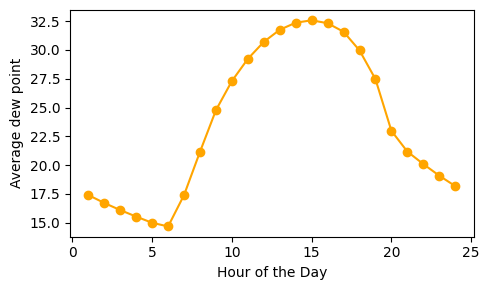

In [18]:
diurnal_data = np_gdf.groupby('Hour')['Dry bulb temperature {C}'].mean()
plt.figure(figsize=(5, 3))
plt.plot(diurnal_data.index, diurnal_data.values, marker='o', linestyle='-', color='orange')

# Step 3: Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Average dew point')

# Optional: Customize the x-axis ticks to show all hours (0-23)

# Show plot
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


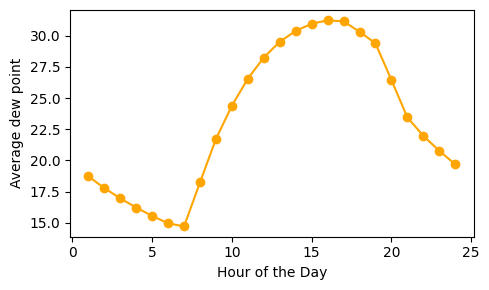

In [19]:
diurnal_data = wrf_gdf.groupby('Hour')['Dry bulb t'].mean()
plt.figure(figsize=(5, 3))
plt.plot(diurnal_data.index, diurnal_data.values, marker='o', linestyle='-', color='orange')

# Step 3: Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Average dew point')

# Optional: Customize the x-axis ticks to show all hours (0-23)

# Show plot
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


In [20]:
np_gdf.columns[5:-1], wrf_gdf.columns[5:-1]

(Index(['Dry bulb temperature {C}', 'Dew point temperature {C}',
        'Relative Humidity {%}', 'Atmospheric Pressure {Pa}',
        'Horizontal Infrared Radiation Intensity from Sky {Wh/m2}',
        'Direct Normal Radiation {Wh/m2}',
        'Diffuse Horizontal Radiation {Wh/m2}', 'Wind Direction {deg}',
        'Wind Speed {m/s}', 'Total Sky Cover {.1}'],
       dtype='object'),
 Index(['Dry bulb t', 'Dew point', 'Relative H', 'Atmospheri', 'Horizontal',
        'Direct Nor', 'Diffuse Ho', 'Wind Direc', 'Wind Speed', 'Total Sky'],
       dtype='object'))

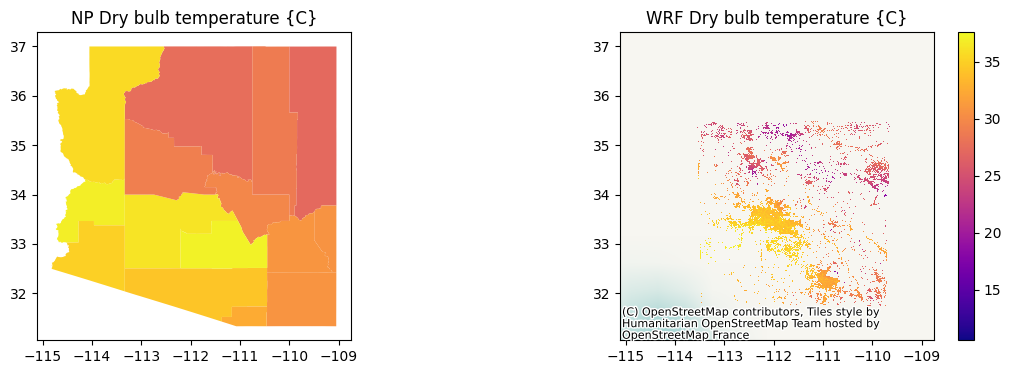

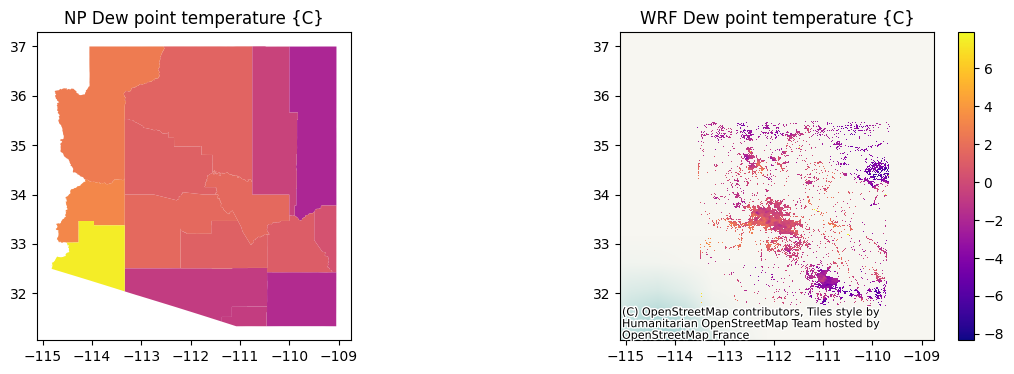

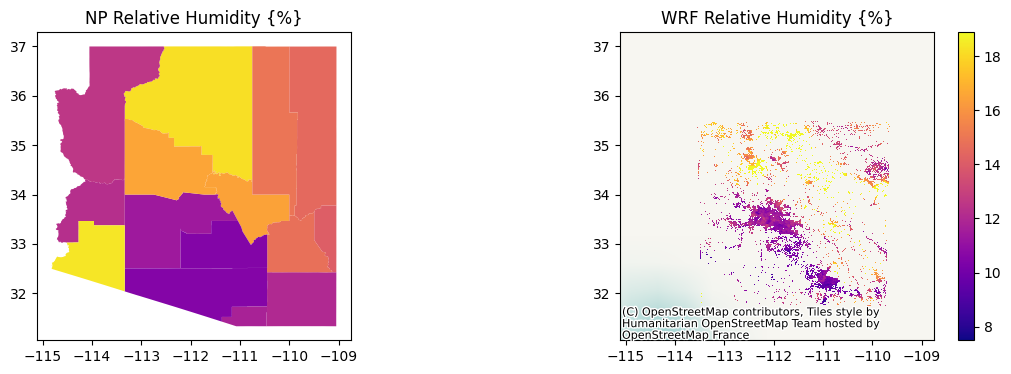

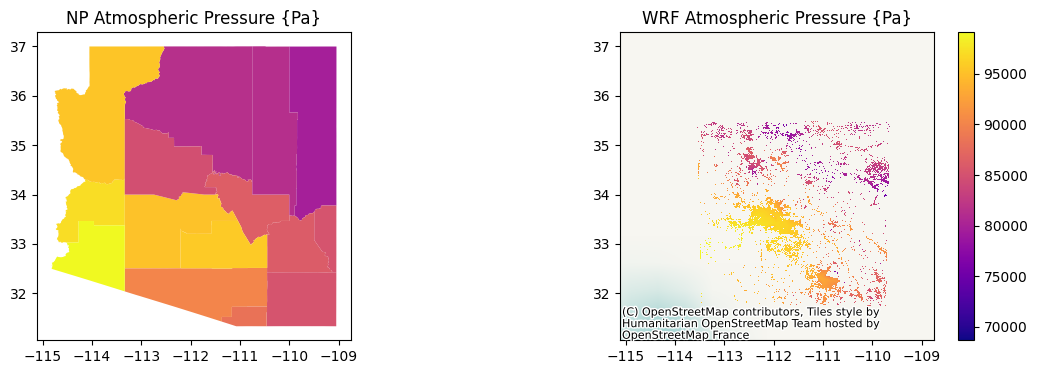

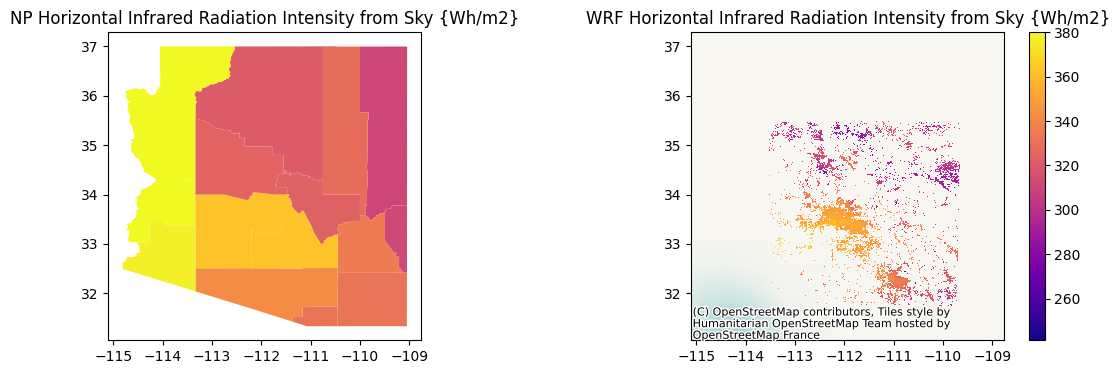

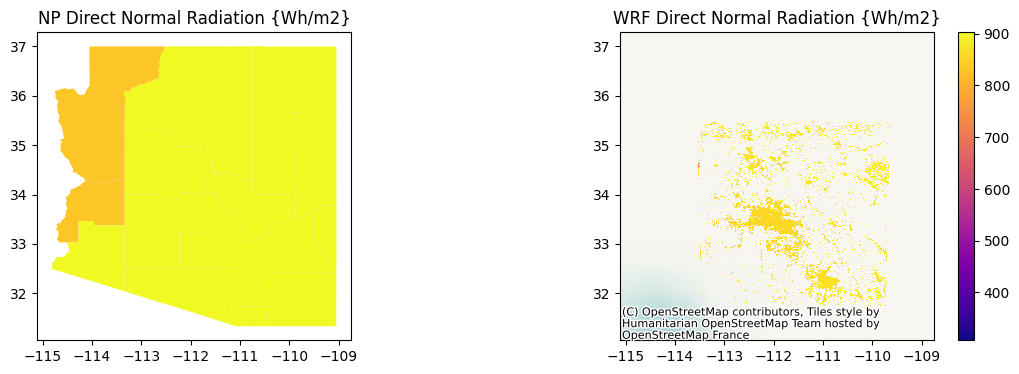

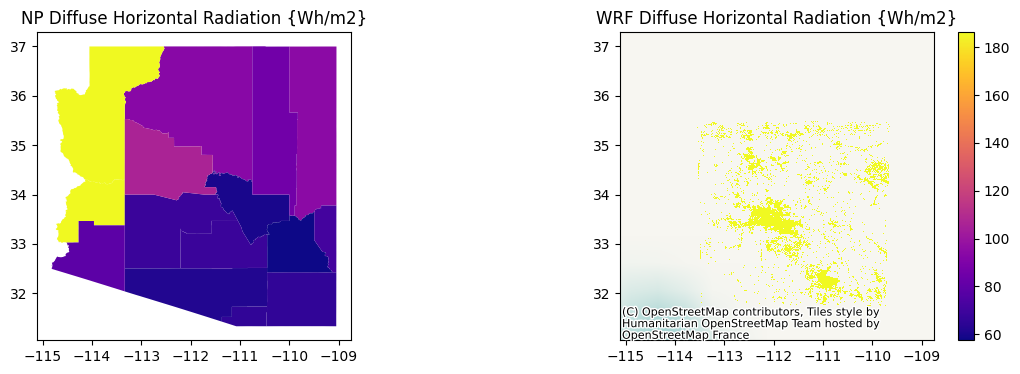

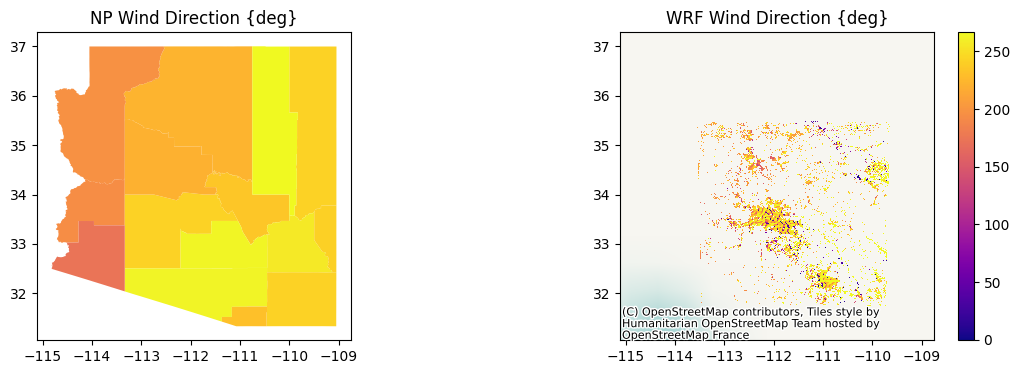

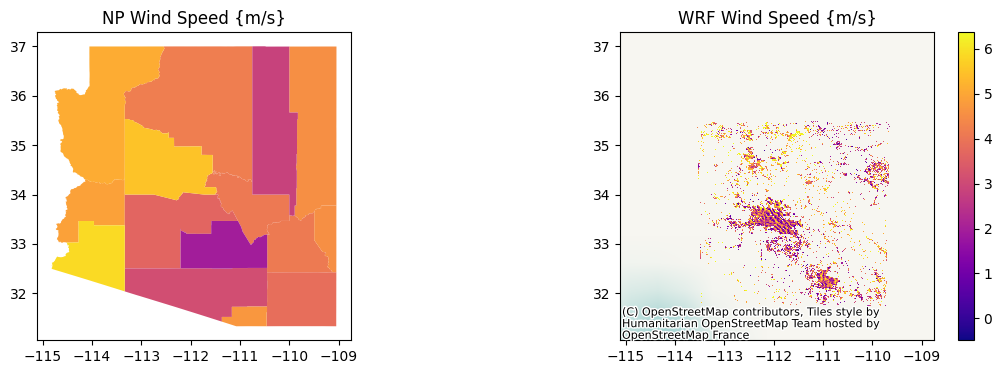

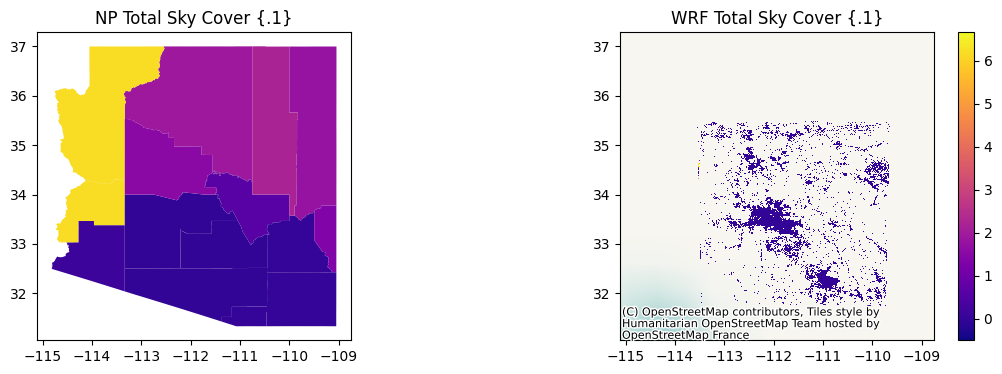

In [21]:
for np_col, wrf_col in zip(np_gdf.columns[5:-1], wrf_gdf.columns[5:-1]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    
    np_plot_data = np_gdf[(np_gdf['Day'] == 16) & (np_gdf['Hour'] == 15)]
    wrf_plot_data = wrf_gdf[(wrf_gdf['Day'] == 16) & (wrf_gdf['Hour'] == 15)]
    
    my_vmin = min(np_plot_data[np_col].min(), wrf_plot_data[wrf_col].min())-.5
    my_vmax = min(np_plot_data[np_col].max(), wrf_plot_data[wrf_col].max())+.5
    
    np_plot_data.plot(ax=ax1, column=np_col, cmap='plasma', vmin=my_vmin, vmax=my_vmax)
    ax1.set_title(f'NP {np_col}')
    
    wrf_plot_data.plot(ax=ax2, legend=True, column=wrf_col, cmap='plasma', vmin=my_vmin, vmax=my_vmax)
    
    ax2.set_title(f'WRF {np_col}')
    ax2.set_xlim(*ax1.get_xlim())
    ax2.set_ylim(*ax1.get_ylim())
    cx.add_basemap(ax2, crs="epsg:4326", zoom=1)
    plt.show()
    

In [22]:
wrf_gdf.columns

Index(['!Year', 'Month', 'Day', 'Hour', 'Minute', 'Dry bulb t', 'Dew point',
       'Relative H', 'Atmospheri', 'Horizontal', 'Direct Nor', 'Diffuse Ho',
       'Wind Direc', 'Wind Speed', 'Total Sky', 'geometry'],
      dtype='object')

In [23]:
np_gdf.columns

Index(['!Year', 'Month', 'Day', 'Hour', 'Minute', 'Dry bulb temperature {C}',
       'Dew point temperature {C}', 'Relative Humidity {%}',
       'Atmospheric Pressure {Pa}',
       'Horizontal Infrared Radiation Intensity from Sky {Wh/m2}',
       'Direct Normal Radiation {Wh/m2}',
       'Diffuse Horizontal Radiation {Wh/m2}', 'Wind Direction {deg}',
       'Wind Speed {m/s}', 'Total Sky Cover {.1}', 'geometry'],
      dtype='object')

In [24]:
a = counties.loc[counties['NAME'] == 'Maricopa'].geometry
print(a.values[0])

POLYGON ((-112.13017446669933 34.044468387657474, -112.13039756087798 34.04449339098042, -112.13475213379691 34.04496505357191, -112.13585943796224 34.04508559077615, -112.13638361147328 34.045143873588245, -112.14562611778237 34.04616055750108, -112.14567120078388 34.04616464642256, -112.14904260220423 34.0464960978185, -112.15222172325625 34.04688123778048, -112.15918530009465 34.047640929442935, -112.16360968102792 34.04809512543073, -112.1648641301925 34.04822527996308, -112.16471779539853 34.04807110352758, -112.16439411220976 34.04802006118105, -112.16381792618009 34.04782486485666, -112.16344697434208 34.04763448526327, -112.16316111368214 34.04737791867278, -112.16290772100668 34.04706918984839, -112.16267950314099 34.04667004080861, -112.16254853228818 34.046053535905855, -112.16252425366113 34.04556453056067, -112.16244202920308 34.045195563718366, -112.16227354901199 34.04480712151049, -112.16219212573402 34.04454636475866, -112.16211618091783 34.04424046535309, -112.1620807

<Axes: >

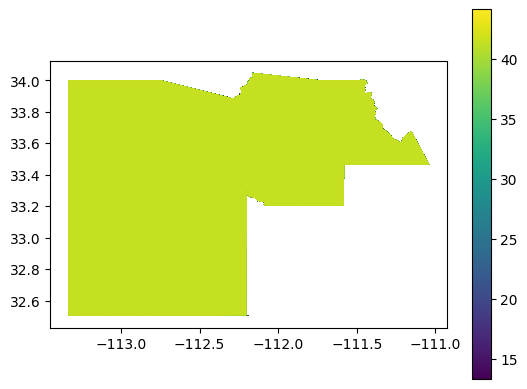

In [25]:
np_gdf[np_gdf['geometry'] == a.values[0]].plot(column='Dry bulb temperature {C}', legend=True)

In [26]:
gdf.iloc[0:10, 1] = gdf.iloc[0:10, 1] * .1

In [27]:
gdf.iloc[0:10, 1]

0     755.309271
1    2625.729777
2     258.060019
3     202.414420
4     177.729490
5     337.376618
6     514.492016
7     164.669235
8     443.899670
9     699.011266
Name: Electricit, dtype: float64

In [28]:
wrf_gdf[wrf_gdf.within(bounds)]['Diffuse Ho'].mean()

105.13711480363966

In [29]:
np_gdf[np_gdf['geometry'] == a.values[0]]['Diffuse Horizontal Radiation {Wh/m2}'].mean()

53.763020833333336

In [30]:
np_gdf.columns

Index(['!Year', 'Month', 'Day', 'Hour', 'Minute', 'Dry bulb temperature {C}',
       'Dew point temperature {C}', 'Relative Humidity {%}',
       'Atmospheric Pressure {Pa}',
       'Horizontal Infrared Radiation Intensity from Sky {Wh/m2}',
       'Direct Normal Radiation {Wh/m2}',
       'Diffuse Horizontal Radiation {Wh/m2}', 'Wind Direction {deg}',
       'Wind Speed {m/s}', 'Total Sky Cover {.1}', 'geometry'],
      dtype='object')

In [31]:
np_gdf[np_gdf['geometry'] == a.values[0]]['Dew point temperature {C}'].mean()

-0.4807812500000001

In [32]:
wrf_gdf.columns

Index(['!Year', 'Month', 'Day', 'Hour', 'Minute', 'Dry bulb t', 'Dew point',
       'Relative H', 'Atmospheri', 'Horizontal', 'Direct Nor', 'Diffuse Ho',
       'Wind Direc', 'Wind Speed', 'Total Sky', 'geometry'],
      dtype='object')

In [33]:
gdf.columns

Index(['ID', 'Electricit', 'NaturalGas', 'Heating_El', 'Cooling_El',
       'Heating_Na', 'Heating_To', 'WaterSyste', 'Lighting_E', 'Equipment_',
       'Fans_Elect', 'Pumps_Elec', 'HeatReject', 'HeatRecove', 'Surface_Ou',
       'Zone_Exfil', 'Zone_Exhau', 'Heat_Rejec', 'Anthropoge', 'Electric_1',
       'NaturalG_1', 'Heating__1', 'Cooling__1', 'Heating__2', 'Heating__3',
       'WaterSys_1', 'Lighting_1', 'Equipmen_1', 'Fans_Ele_1', 'Pumps_El_1',
       'HeatReje_1', 'HeatReco_1', 'Surface__1', 'Zone_Exf_1', 'Zone_Exh_1',
       'Heat_Rej_1', 'Anthropo_1', 'geometry'],
      dtype='object')

In [34]:
phx = gdf[gdf.within(bounds)]

In [35]:
phx

ID    Electricit   NaturalGas  Heating_El   Cooling_El  \
402762   8100000749253   5814.395595  1194.972662    0.000000  2154.192559   
402763   8100000803746    411.915915    64.097458    0.000000   226.807088   
402764   8100000779426    637.386114    98.079958    0.000000   324.844550   
402765   8100000817963    711.494635   112.108452    0.000000   353.359669   
402766   8100000846735   3247.612438   663.317273    0.000000  1232.668676   
...                ...           ...          ...         ...          ...   
1490216  8100002313473  18459.856194  2206.299294    0.000000  6684.558407   
1490217  8100002323046  11432.156569    53.001390    0.000000  5790.635403   
1490218  8100002322472   3351.720624   443.848407    0.000000  1628.369323   
1490220  8100002313072  13422.085170   219.132103    0.000000  4926.429048   
1490221  8100002311408  14093.397819   213.247837    3.750572  5525.882630   

         Heating_Na  Heating_To   WaterSyste   Lighting_E   Equipment_  ...  \
402762     0.000000    0.000000   738.039660   332.841907  2001.695452  ...   
402763     9.704434    9.704434    14.395426    14.228412    91.113606  ...   
402764     2.475056    2.475056    34.724481    25.461316   160.147510  ...   
402765     1.359908    1.359908    42.777368    29.616914   185.514585  ...   
402766     0.000000    0.000000   380.463360   183.354023  1111.120958  ...   
...             ...         ...          ...          ...          ...  ...   
1490216    0.000000    0.000000  2988.936412  3189.282213  3695.765938  ...   
1490217   28.499675   28.499675     0.000000  1350.617076  1183.963263  ...   
1490218    5.771646    5.771646   396.051302   116.618575   733.821189  ...   
1490220  171.664967  171.664967     0.000000  2186.682917  1906.898518  ...   
1490221    0.000000    3.750572     0.000000  3273.663224  4574.000386  ...   

          Fans_Ele_1    Pumps_El_1  HeatReje_1  HeatReco_1  Surface__1  \
402762    587.278832  9.029570e-09         0.0         0.0   35.557121   
402763     64.304289  1.761030e-10         0.0         0.0    3.529858   
402764     91.838774  4.248200e-10         0.0         0.0    5.191128   
402765     99.793215  5.233410e-10         0.0         0.0    5.644409   
402766    336.472288  4.654710e-09         0.0         0.0   19.884923   
...              ...           ...         ...         ...         ...   
1490216  1884.137751  4.432537e-08         0.0         0.0   74.585524   
1490217  3085.033856  1.366613e-01         0.0         0.0   21.406624   
1490218   473.589046  5.873369e-09         0.0         0.0   18.863006   
1490220  4068.526014  2.648807e-01         0.0         0.0   29.257680   
1490221  1018.442269  2.726149e-01         0.0         0.0   47.675600   

         Zone_Exf_1  Zone_Exh_1  Heat_Rej_1  Anthropo_1  \
402762    -0.028133         0.0         0.0   35.528987   
402763    -0.033004         0.0         0.0    3.496853   
402764    -0.039418         0.0         0.0    5.151709   
402765    -0.040917         0.0         0.0    5.603492   
402766    -0.054219         0.0         0.0   19.830704   
...             ...         ...         ...         ...   
1490216   -0.465061         0.0         0.0   74.120463   
1490217    0.511961         0.0         0.0   21.918584   
1490218   -0.185545         0.0         0.0   18.677460   
1490220    0.638923         0.0         0.0   29.896603   
1490221   -0.009959         0.0         0.0   47.665641   

                                                  geometry  
402762   POLYGON ((-111.97084 32.80124, -111.97084 32.8...  
402763   POLYGON ((-111.97084 32.80124, -111.97084 32.8...  
402764   POLYGON ((-111.97084 32.80124, -111.97084 32.8...  
402765   POLYGON ((-111.97084 32.80124, -111.97084 32.8...  
402766   POLYGON ((-111.97084 32.80124, -111.97084 32.8...  
...                                                    ...  
1490216  POLYGON ((-112.18333 33.98755, -112.18333 33.9...  
1490217  POLYGON ((-112.18333 33.98755, -112.183

In [36]:
wrf_elec = phx['Electricit']

In [37]:
np_elec = phx['Electric_1']

In [38]:
change = percent_change(np_elec, wrf_elec)
((wrf_elec[change > 0]-np_elec[change > 0]).sum())/np_elec[change > 0].sum()


0.028237250001288905

In [39]:
((wrf_elec[change < 0]-np_elec[change < 0]).sum())/np_elec[change < 0].sum()


-0.02553303360903378

In [40]:
tmp = change.to_frame(name='Change')
_gdf = gpd.GeoDataFrame(tmp, geometry=phx['geometry'])

In [41]:
lower_quantile = _gdf['Change'].quantile(q=.03, interpolation='higher')
upper_quantile = _gdf['Change'].quantile(q=.97, interpolation='lower')
    # cells_gdf[(series > lower_quantile) & (series < upper_quantile)].plot(column=f'{key}_change', ax=ax1, legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=lower_quantile, vmax=upper_quantile))


new_gdf = _gdf[(_gdf['Change'] > lower_quantile) & (_gdf['Change'] < upper_quantile)]#.plot(column='Change', legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=lower_quantile, vmax=upper_quantile))

In [42]:
new_gdf[new_gdf['Change'] < 0]['Change'].mean()

-2.043072632180517

In [43]:
len(new_gdf[new_gdf['Change'] < 0].index)

211315

In [44]:
new_gdf[new_gdf['Change'] > 0]['Change'].mean()

3.6642990616209836

In [45]:
len(new_gdf[new_gdf['Change'] > 0].index)

768173

In [46]:
(gdf[gdf.within(bounds)]['Electricit'].sum()-gdf[gdf.within(bounds)]['Electric_1'].sum())/gdf[gdf.within(bounds)]['Electric_1'].sum()


0.00039135418860078604

In [47]:
print(f"{len(cells_gdf[(cells_gdf['Electricity_Facility_change'] > -1) & (cells_gdf['Electricity_Facility_change'] < 1)].index)=}")
print(f"{len(cells_gdf[cells_gdf['Electricity_Facility_change'] < -1].index)=}")
print(f"{len(cells_gdf[cells_gdf['Electricity_Facility_change'] > 1].index)=}")

len(cells_gdf[(cells_gdf['Electricity_Facility_change'] > -1) & (cells_gdf['Electricity_Facility_change'] < 1)].index)=3081
len(cells_gdf[cells_gdf['Electricity_Facility_change'] < -1].index)=7513
len(cells_gdf[cells_gdf['Electricity_Facility_change'] > 1].index)=10075


In [48]:
cells_gdf[cells_gdf['Electricity_Facility_change'] < 0]['Electricity_Facility_change'].median()

-3.4206762294493447

In [49]:
cells_gdf[cells_gdf['Electricity_Facility_change'] > 0]['Electricity_Facility_change'].median()

4.422531882412423

<Axes: >

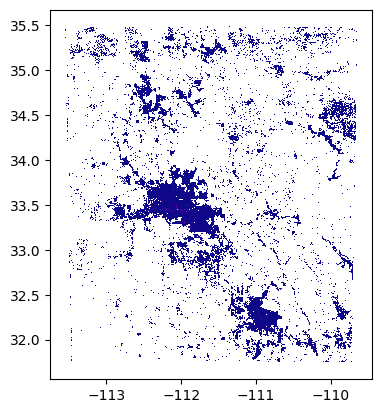

In [50]:
gdf.plot(column='Electricit', cmap='plasma')

In [51]:
gdf['electric_change'] = percent_change(gdf['Electric_1'], gdf['Electricit'])

<Axes: >

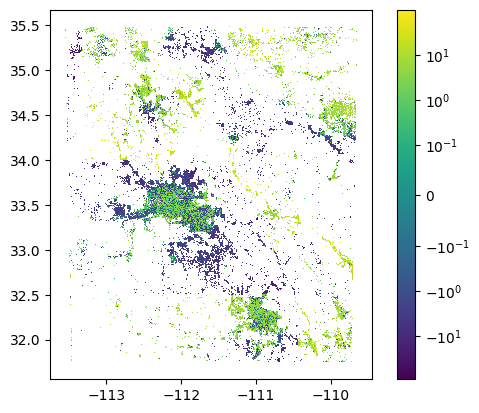

In [52]:
gdf.plot(column='electric_change', legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=gdf['electric_change'].min(), vmax=gdf['electric_change'].max()))

<Axes: >

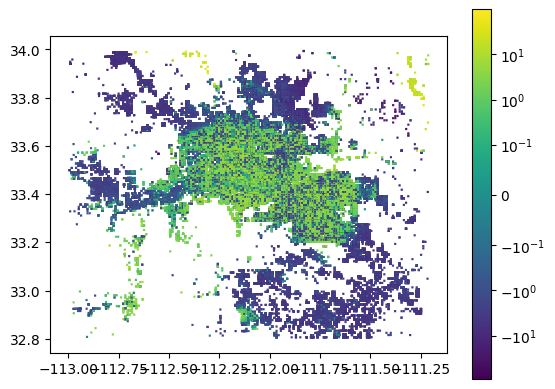

In [53]:
gdf[gdf.within(bounds)].plot(column='electric_change', legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=gdf['electric_change'].min(), vmax=gdf['electric_change'].max()))

<Axes: >

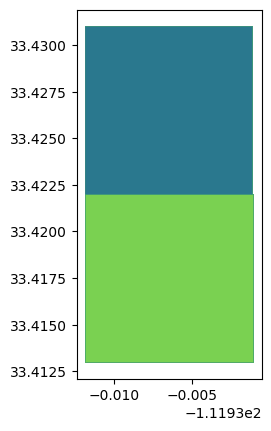

In [54]:
# asu_bounds = Polygon([(-113, 34),(-113, 32.8),(-111.2, 32.8),(-111.2, 34)])
asu_bounds = Polygon([(-111.943848, 33.432501),(-111.943848, 33.411016),(-111.926077, 33.411016),(-111.926077, 33.432501)])
# gdf[gdf.within(asu_bounds)].plot(column='electric_change', legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=gdf['electric_change'].min(), vmax=gdf['electric_change'].max()))
gdf[gdf.within(asu_bounds)].plot(column='electric_change', markersize=0.0000005)

In [55]:
gdf[gdf.within(asu_bounds)]

ID    Electricit     NaturalGas  Heating_El     Cooling_El  \
823318  8100000964305  1.773564e+03     278.158440         0.0     851.683070   
823319  8100000976810  1.409548e+03     207.102633         0.0     709.044137   
823320  8100000991805  2.142017e+03     419.853977         0.0     856.612544   
823321  8100000987281  1.877226e+03     352.270418         0.0     782.566291   
823322  8100001004693  1.602412e+03     299.838726         0.0     674.655667   
...               ...           ...            ...         ...            ...   
855891  8100000999398  1.187825e+04    1807.580446         0.0    4623.357538   
855892  8100001005524  2.594689e+03     358.776409         0.0    1267.067004   
855893  8100001058106  2.301181e+05   12076.594798         0.0   89569.669358   
855894  8100001078426  3.307023e+04    4240.329859         0.0   15242.755291   
855895  8100000955572  1.143256e+06  159192.040142         0.0  467925.811856   

        Heating_Na  Heating_To   WaterSyste     Lighting_E     Equipment_  \
823318    0.000000    0.000000   139.048274      75.823400     465.942446   
823319    0.000000    0.000000    96.461784      56.119039     346.917056   
823320    0.000000    0.000000   227.875752     115.301908     703.296253   
823321    0.000000    0.000000   187.299492      96.557073     590.087218   
823322    0.000000    0.000000   153.426638      81.901190     502.259033   
...            ...         ...          ...            ...            ...   
855891    0.000000    0.000000  2460.639022     497.028591    3027.873082   
855892    0.000000    0.000000   270.939649      96.685667     600.985385   
855893    0.000000    0.000000     0.000000   39144.215475   32407.436919   
855894    0.000000    0.000000  1653.242653    3695.508349    7102.964997   
855895  138.927457  138.927457     0.000000  246504.206414  224679.805337   

        ...    Pumps_El_1  HeatReje_1  HeatReco_1  Surface__1  Zone_Exf_1  \
823318  ...  1.701169e-09         0.0         0.0   11.986576   -0.098095   
823319  ...  1.180148e-09         0.0         0.0   10.564509   -0.069554   
823320  ...  2.787920e-09         0.0         0.0   14.007988   -0.043231   
823321  ...  2.291493e-09         0.0         0.0   12.803004   -0.041373   
823322  ...  1.877079e-09         0.0         0.0   10.922322   -0.043213   
...     ...           ...         ...         ...         ...         ...   
855891  ...  3.649092e-08         0.0         0.0   46.363603   -0.183966   
855892  ...  3.814079e-09         0.0         0.0   14.232381   -0.115738   
855893  ...  1.166022e-07         0.0         0.0  166.284479  -17.591621   
855894  ...  2.022621e-08         0.0         0.0  161.719865   -1.437286   
855895  ...  3.764931e+04         0.0         0.0  642.879954   -2.088465   

        Zone_Exh_1  Heat_Rej_1  Anthropo_1  \
823318         0.0         0.0   11.888482   
823319         0.0         0.0   10.494955   
823320         0.0         0.0   13.964757   
823321         0.0         0.0   12.761632   
823322         0.0         0.0   10.879108   
...            ...         ...         ...   
855891         0.0         0.0   46.179638   
855892         0.0         0.0   14.116644   
855893         0.0         0.0  148.692858   
855894         0.0         0.0  160.282579   
855895         0.0         0.0  640.791489   

                                                 geometry  electric_change  
823318  POLYGON ((-111.94179 33.41298, -111.94179 33.4...         7.383100  
823319  POLYGON ((-111.94179 33.41298, -111.94179 33.4...         6.725608  
823320  POLYGON ((-111.94179 33.41298, -111.94179 33.4...         6.060888  
823321  POLYGON ((-111.94179 33.41298, -111.94179 33.4...         5.941896  
823322  POLYGON ((-111.94179 33.41298, -111.94179 33.4...         6.414551  
...                                                   ...              ...  
855891  POLYGON ((-111.94184 33.42198, -111.94184 33.4...         3.704815  
855892  POLYGON ((-111.9418

In [56]:
bldgs_centroids = gpd.read_file('building_results_centroids', use_arrow=True)

<Axes: >

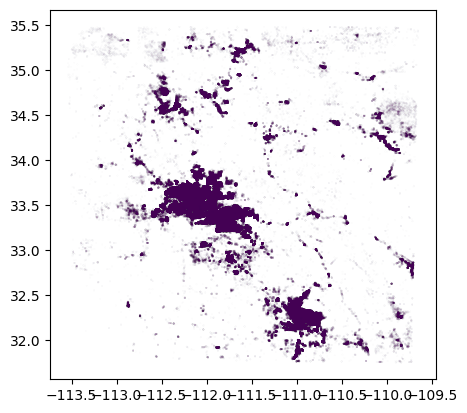

In [57]:
bldgs_centroids.plot('Electricit', markersize=0.00005)

In [58]:
bldgs_centroids['electric_change'] = percent_change(bldgs_centroids['Electric_1'], bldgs_centroids['Electricit'])

<Axes: >

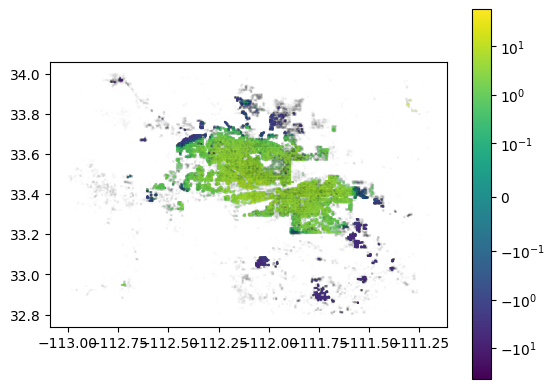

In [59]:
bldgs_centroids[bldgs_centroids.within(bounds)].plot(column='electric_change', legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=bldgs_centroids[bldgs_centroids.within(bounds)]['electric_change'].min(), vmax=bldgs_centroids[bldgs_centroids.within(bounds)]['electric_change'].max()), markersize=0.000005)

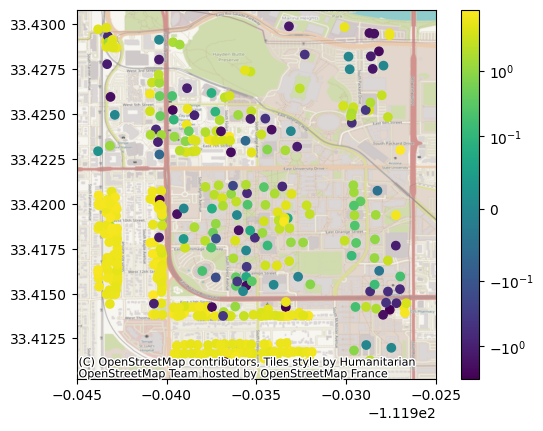

In [60]:
ax = bldgs_centroids[bldgs_centroids.within(asu_bounds)].plot(column='electric_change', legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=bldgs_centroids[bldgs_centroids.within(asu_bounds)]['electric_change'].min(), vmax=bldgs_centroids[bldgs_centroids.within(asu_bounds)]['electric_change'].max()))
ax.set_xticks(ax.get_xticks()[::2])
cx.add_basemap(ax=ax, crs='epsg:4326')

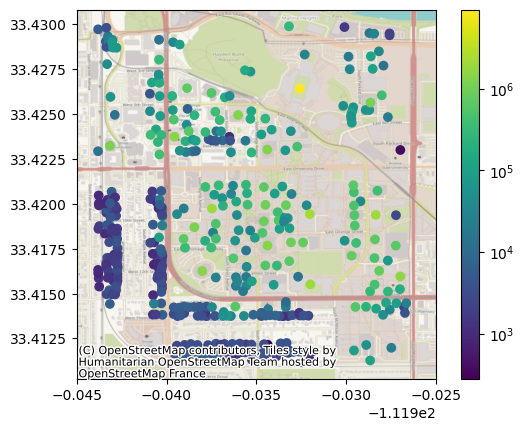

In [67]:
ax = bldgs_centroids[bldgs_centroids.within(asu_bounds)].plot(column='Electricit', legend=True,
                                                              norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=
                                                              bldgs_centroids[bldgs_centroids.within(asu_bounds)][
                                                                  'Electricit'].min(), vmax=bldgs_centroids[
                                                                  bldgs_centroids.within(asu_bounds)][
                                                                  'Electricit'].max()))
cx.add_basemap(ax=ax, crs='epsg:4326')
ax.set_xticks(ax.get_xticks()[::2])
bounds = Polygon([(-113, 34),(-113, 32.8),(-111.2, 32.8),(-111.2, 34)])


In [70]:
bldgs_centroids[bldgs_centroids.within(asu_bounds)]['Electricit'].mean()

160227.43986919447

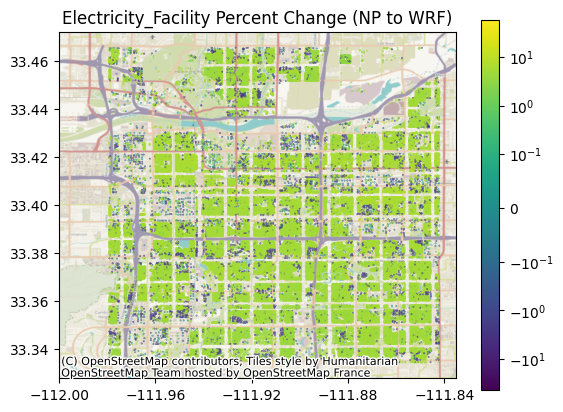

In [62]:
bounds2 = Polygon([(-111.979378, 33.465415),(-111.979378, 33.334527),(-111.841991, 33.334527),(-111.841991, 33.465415)])

ax = bldgs_centroids[bldgs_centroids.within(bounds2)].plot(column='electric_change', legend=True,
                                                     norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=
                                                     bldgs_centroids[bldgs_centroids.within(bounds)][
                                                         'electric_change'].min(), vmax=bldgs_centroids[
                                                         bldgs_centroids.within(bounds)]['electric_change'].max()),
                                                      markersize=0.1)
ax.set_title('Electricity_Facility Percent Change (NP to WRF)')
ax.set_xticks(ax.get_xticks()[::2])
cx.add_basemap(ax=ax, crs='epsg:4326')

In [72]:
bldgs_centroids[bldgs_centroids.within(bounds2)]['Electricit'].mean()

10352.282698850295

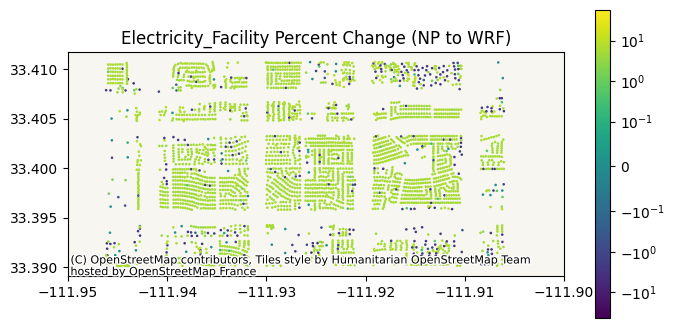

In [63]:
bounds3 = Polygon([(-111.9461565, 33.410712),(-111.9461565, 33.390146),(-111.906052, 33.390146),(-111.906052, 33.410712)])
fig, ax = plt.subplots(figsize=(8, 4))
bldgs_centroids[bldgs_centroids.within(bounds3)].plot(ax=ax,column='electric_change', legend=True,
                                                     norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=
                                                     bldgs_centroids[bldgs_centroids.within(bounds)][
                                                         'electric_change'].min(), vmax=bldgs_centroids[
                                                         bldgs_centroids.within(bounds)]['electric_change'].max()),
                                                      markersize=0.75)
ax.set_xticks(ax.get_xticks()[::2])
ax.set_title('Electricity_Facility Percent Change (NP to WRF)')
cx.add_basemap(ax, crs='epsg:4326', zoom=1)

In [64]:
bldgs_centroids.columns

Index(['ID', 'Electricit', 'NaturalGas', 'Heating_El', 'Cooling_El',
       'Heating_Na', 'Heating_To', 'WaterSyste', 'Lighting_E', 'Equipment_',
       'Fans_Elect', 'Pumps_Elec', 'HeatReject', 'HeatRecove', 'Surface_Ou',
       'Zone_Exfil', 'Zone_Exhau', 'Heat_Rejec', 'Anthropoge', 'Electric_1',
       'NaturalG_1', 'Heating__1', 'Cooling__1', 'Heating__2', 'Heating__3',
       'WaterSys_1', 'Lighting_1', 'Equipmen_1', 'Fans_Ele_1', 'Pumps_El_1',
       'HeatReje_1', 'HeatReco_1', 'Surface__1', 'Zone_Exf_1', 'Zone_Exh_1',
       'Heat_Rej_1', 'Anthropo_1', 'CZ', 'Centroid', 'State_Abbr',
       'Footprint2', 'Height', 'Area2D', 'BuildingTy', 'NumFloors', 'Area',
       'Standard', 'NumWalls', 'WWR_surfac', 'lat', 'lon', 'old_geo',
       'geometry', 'electric_change'],
      dtype='object')

In [65]:
foo = bldgs_centroids[bldgs_centroids.within(bounds)]

In [66]:
np = foo['Surface_Ou'].sum()
wrf = foo['Surface__1'].sum()
(wrf-np)/np

-0.16009257765290746